## Model building
## Models - Order by best score

### Model 1:
#### Score: 0.96123
#### I used XGB ensemble classifer with the train data sampled using SMOTE. I used stratification to train the data model for cross validation. The score improved by a slight margin compared to my previous best. This model's hyperparameters were tuned using GridSearchCV.

### Model 2:
#### Score: 0.93394
#### I used lightGBM ensemble classifier with the train data sampled using SMOTE. The score improved with SMOTE and using lightGBM.

### Model 3:
#### Score: 0.920384
#### I used random forest classifier for this approach. The train data was sampled using SMOTEENN

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
print('Libraries imported')

Libraries imported



#### I'm making a fresh data load and performing data preprocessing and feature engineering in this file

## Data Load

In [32]:
#train data
customers_train_df = pd.read_csv('orig/customers_train.csv')
customers_df = customers_train_df.copy()

accounts_train_df = pd.read_csv('orig/accounts_train.csv')
accounts_df = accounts_train_df.copy()

transactions_train_df = pd.read_csv('orig/transactions_train.csv')
transactions_df = transactions_train_df.copy()

In [33]:
grouped_accounts_df = pd.DataFrame(accounts_df.groupby(['Customer'])['Account'].count()).reset_index()

grouped_transactions_df = pd.DataFrame(transactions_df.groupby(['Customer'])['Amount'].count()).reset_index()

df = pd.merge(pd.merge(customers_df, grouped_accounts_df, on=['Customer'], how='left'), grouped_transactions_df, on=['Customer'], how='left')

In [34]:
#test data
customers_test_df = pd.read_csv('orig/customers_test.csv')
customers_test_df = customers_test_df.copy()

accounts_test_df = pd.read_csv('orig/accounts_test.csv')
accounts_test_df = accounts_test_df.copy()

transactions_test_df = pd.read_csv('orig/transactions_test.csv')
transactions_test_df = transactions_test_df.copy()

grouped_test_accounts_df = pd.DataFrame(accounts_test_df.groupby(['Customer'])['Account'].count()).reset_index()

grouped_test_transactions_df = pd.DataFrame(transactions_test_df.groupby(['Customer'])['Amount'].count()).reset_index()

df_predict = pd.merge(pd.merge(customers_test_df, grouped_test_accounts_df, on=['Customer'], how='left'), grouped_test_transactions_df, on=['Customer'], how='left')

In [35]:
df.dropna(subset=['Churn'], inplace=True)

### Change Education and Income to ordered categorical data as they have a natural order

In [36]:
df['Income'] = pd.Categorical(df['Income'], 
                              ordered=True, 
                              categories=['Unknown','Less than €30K', '€30K - €50K', '€50K - €80K', '€80K - €100K', '€100K +'])

df['Education'] = pd.Categorical(df['Education'], 
                              ordered=True, 
                              categories=['Unknown','Primary level', 'Second level', 'Graduate', 'MSc', 'PhD','Post LC'])

df_predict['Income'] = pd.Categorical(df_predict['Income'], 
                              ordered=True, 
                              categories=['Unknown','Less than €30K', '€30K - €50K', '€50K - €80K', '€80K - €100K', '€100K +'])

df_predict['Education'] = pd.Categorical(df_predict['Education'], 
                              ordered=True, 
                              categories=['Unknown','Primary level', 'Second level', 'Graduate', 'MSc', 'PhD','Post LC'])


### Change other object types to categorical 

In [37]:
df.Churn = pd.Categorical(df.Churn)
df.Card = pd.Categorical(df.Card)
df.Gender = pd.Categorical(df.Gender)
df.Marital_Status = pd.Categorical(df.Marital_Status)
df.Account = pd.Categorical(df.Account)
df.Start_Date = pd.to_datetime(df.Start_Date)

df_predict.Card = pd.Categorical(df_predict.Card)
df_predict.Gender = pd.Categorical(df_predict.Gender)
df_predict.Marital_Status = pd.Categorical(df_predict.Marital_Status)
df_predict.Account = pd.Categorical(df_predict.Account)
df_predict.Start_Date = pd.to_datetime(df.Start_Date)

## Missing Values

### Marital_Status
#### Fill null values in the Marital_Status column with a new category called "Unknown". One other alternative to handle this was to fill null values with most popular category in Marital_Status column. I didn't chose that as it may distort the prediction. 

### Age
#### Replace values in the Age column by replacing with median of that column. I chose median over mean as it is more robust to outliers. However, I tried both strategy and didn't notice any difference in the output.  

In [38]:
df["Marital_Status"] = df["Marital_Status"].cat.add_categories("Unknown")
df['Marital_Status'].fillna('Unknown', inplace=True)

In [39]:
from sklearn.impute import SimpleImputer
mean_imputer = SimpleImputer(strategy='median')
df['Age'] = mean_imputer.fit_transform(df['Age'].values.reshape(-1,1))

### New feature extraction

#### We can split date and extract 3 more feature as it may contribute to prediction accuracy

In [40]:
#extract 3 features from date
df['Start_Year'] = df['Start_Date'].dt.year
df['Start_Month'] = df['Start_Date'].dt.month
df['Start_Day'] = df['Start_Date'].dt.day

df_predict['Start_Year'] = df_predict['Start_Date'].dt.year
df_predict['Start_Month'] = df_predict['Start_Date'].dt.month
df_predict['Start_Day'] = df_predict['Start_Date'].dt.day

# Model Construction

### Encoding categorical values:
#### We are using sklearn's LabelEncoder to convert categorical values into numerical data
#### The integer codes generated by the LabelEncoder are used to represent the categorical variable in the machine learning model. This encoding is necessary because most machine learning algorithms can only handle numerical data.


In [42]:
from sklearn.preprocessing import LabelEncoder

le_dict = {}
le_predict_dict = {}
for col in df.columns:
    if df[col].dtype == 'category':
        le_dict[col] = LabelEncoder()
        df[col] = le_dict[col].fit_transform(df[col])

for col in df_predict.columns:
    if df_predict[col].dtype == 'category':
        le_predict_dict[col] = LabelEncoder()
        df_predict[col] = le_predict_dict[col].fit_transform(df_predict[col])

### Preparing test and train variables
#### Based on the feature importance score, It was observed that the Start_Date and Start_Day features were not contributing to prediction and have hence removed it. 

In [43]:
y=df['Churn']

X=df.drop(['Churn', 'Start_Date', 'Start_Day'],axis=1)



### Oversampling using SMOTE
#### From the EDA it was observed the data in the Churn column is skewed as there were only 20% of rows that had Churn as Yes and the remaining rows had Churn value as No. 
#### The below code will perform oversampling by adding synthetic data to balance the imbalanced classes in the target i.e Churn


In [44]:
# import library
# oversampling

from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
X1, y1 = smote.fit_resample(X, y)

print('Original dataset shape', y.value_counts())
print('Resample dataset shape', y1.value_counts())

Original dataset shape 0    5522
1    1034
Name: Churn, dtype: int64
Resample dataset shape 0    5522
1    5522
Name: Churn, dtype: int64


#### The SMOTEEN function performs a combination of oversampling using SMOTE and undersampling using Edited Nearest Neighbours (ENN) to balance the imbalanced dataset. The sampling_strategy parameter is set to 'auto', which means the minority class is oversampled to have the same number of samples as the majority class, and then ENN is applied to remove any samples that are considered noisy or borderline. I have commented it as SMOTEENN as I chose to go with SMOTE as it yielded better accuracy. 

In [45]:
# from imblearn.combine import SMOTEENN

# # Instantiate the SMOTEENN object with desired parameters
# smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)

# # Fit and transform the data
# X1, y1 = smote_enn.fit_resample(X, y)

# print('Original dataset shape', y.value_counts())
# print('Resample dataset shape', y1.value_counts())

# X= X1
# y = y1

### Split test and train data
#### The 20% of the train data is allocated for test and remaining 80% is allocated for training the model.

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

#### Given a model the below function prints the accuracy score, F1 score and recall score.

In [47]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,f1_score,recall_score

def accuracy(model):
    model.fit(X_train, y_train)
#     model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='auc', early_stopping_rounds=1000, verbose=100)
    predict = model.predict(X_test)
    print("Model ", i,":", model)
    print('Accuracy score:',accuracy_score(y_test, predict))
    print('F1 score:',f1_score(y_test, predict))
    print('Recall score:', recall_score(y_test, predict))
    print(confusion_matrix(y_test, predict))
    return y_test, predict

### Running data against all models
#### In the below snippet, I'm training my data against 8 different models to chose the best performing model based on recall score and accuracy. I have managed to chose atleast 1 model from every category such as Instances, Hyperplanes, Decision trees, Probabilistic to cover more ground with minimum effort. 

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.cluster import KMeans

model1 = RandomForestClassifier()
model2 = SVC()
model3 = LogisticRegression()
model4 = KNeighborsClassifier()
model5 = SGDClassifier()
model6 = DecisionTreeClassifier()
model7 = GaussianNB()
model8 = SVC()
    
models=[model1,model2,model3,model4,model5,model6,model7,model8]

i=0

for model in models:
    i+=1
    y_test, predict=accuracy(model)


Model  1 : RandomForestClassifier()
Accuracy score: 0.9161585365853658
F1 score: 0.7222222222222223
Recall score: 0.6441441441441441
[[1059   31]
 [  79  143]]
Model  2 : SVC()
Accuracy score: 0.8307926829268293
F1 score: 0.0
Recall score: 0.0
[[1090    0]
 [ 222    0]]
Model  3 : LogisticRegression()
Accuracy score: 0.8307926829268293
F1 score: 0.0
Recall score: 0.0
[[1090    0]
 [ 222    0]]
Model  4 : KNeighborsClassifier()
Accuracy score: 0.8041158536585366
F1 score: 0.022813688212927757
Recall score: 0.013513513513513514
[[1052   38]
 [ 219    3]]
Model  5 : SGDClassifier()
Accuracy score: 0.8307926829268293
F1 score: 0.0
Recall score: 0.0
[[1090    0]
 [ 222    0]]
Model  6 : DecisionTreeClassifier()
Accuracy score: 0.8605182926829268
F1 score: 0.5734265734265734
Recall score: 0.5540540540540541
[[1006   84]
 [  99  123]]
Model  7 : GaussianNB()
Accuracy score: 0.8307926829268293
F1 score: 0.0
Recall score: 0.0
[[1090    0]
 [ 222    0]]
Model  8 : SVC()
Accuracy score: 0.8307926

### Choosing a model
#### From the above output it can be observed that the dataset responds well to RandomForestClassifier as it yields better accuracy and recall score compared to other models. As RandomForest is a decision tree based classification model. We can arrive at a conclusion that the our data reponds well to decision tree based models. 

### Ensemble learning model
#### An ensemble machine learning algorithm is a technique that combines the predictions of multiple individual machine learning models to improve the overall predictive power and reduce the risk of overfitting.
#### In the below section i'm using XGBClassifier which is a decision tree-based ensemble machine learning algorithm that uses a gradient boosting framework. This model will use multiple decision tree-based models to minimize prediction error by optimizing a specified differentiable loss function.

In [49]:
#run xgb classifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score

from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Model ", i,":", model)
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Recall score:', recall_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Model  8 : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy score: 0.9184451219512195
F1 score: 0.7358024691358024
Recall score: 0.6711711711711712
[[1056   34]
 [  73  149]]


#### From the above output it can be observed that XGBClassifier has yielded better accuracy, recall and F1 score compared to RandomForestClassifier.

### Stratification
#### On top of SMOTE I'm using Stratification to further balance the bias on the distribution of classes between the two sets.
#### This has improved the overall accuracy, recall and F1 score by 2 %

In [50]:
#XGB using stratify
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score

# create your classifier with default hyperparameters
clf = xgb.XGBClassifier()

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# iterate over the splits and train/test the classifier
for train_idx, test_idx in skf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
    
    
y_test, predict=accuracy(clf)
print('Accuracy score:',accuracy_score(y_test, predict))
print('F1 score:',f1_score(y_test, predict)) 
print('Recall score:', recall_score(y_test, predict))

Accuracy score: 0.9176327028676022
Accuracy score: 0.9176327028676022
Accuracy score: 0.9243441122635754
Accuracy score: 0.9237339841366687
Model  8 : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy score: 0.9237339841366687
F1 score: 0.7412008281573499
Recall score: 0.6911196911196911


### Feature Importance
#### This is a checkpoint where I checked if the features I chose are contributing to the prediction. Features that do not contribute to the prediction will have near zero or absolute zero as value. 

In [51]:
# Print feature importances
importances = clf.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(feature, importance)

Customer 0.029691672
Card 0.033140086
Customer_Service_Calls 0.07004687
Credit_Limit 0.04584708
Total_Revolving_Balance 0.15076903
Average_Open_To_Buy 0.052530408
Average_Utilisation_Ratio 0.03434571
Age 0.03930408
Gender 0.0644592
Education 0.02824019
Marital_Status 0.040521264
Dependents 0.038214196
Income 0.033654124
Account 0.13505816
Amount 0.14523976
Start_Year 0.029466059
Start_Month 0.02947214


### Hyperparameter tuning
#### To further improve the metrics, I'm using GridSearchCV to check for hyperparameters that would yeild better metrics. I'm tuning the search based on recall as we are evaluating this model based on recall score

In [165]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold

# Define the XGBClassifier model
xgb_model = XGBClassifier()

# Define the parameter grid to search over
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'gamma': [0, 1, 5],
}

# Define the scoring metric to use
scoring = {'recall': 'recall'}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Define the GridSearchCV object
grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    scoring=scoring,
    cv=cv,
    refit='recall',
    verbose=3,
    n_jobs=-1
)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Print the best parameter values and the corresponding recall score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best recall score: {grid_search.best_score_}')


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; recall: (test=0.452) total time=   0.3s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; recall: (test=0.482) total time=   0.6s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; recall: (test=0.536) total time=   0.5s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; recall: (test=0.428) total time=   1.0s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; recall: (test=0.554) total time=   1.0s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=0.8; recall: (test=0.422) total time=   0.3s
[CV 4/5] END colsample_bytree=0.5, gam

[CV 5/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.5, max_depth=3, n_estimators=200, subsample=0.8; recall: (test=0.771) total time=   0.8s
[CV 2/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.5, max_depth=4, n_estimators=50, subsample=0.8; recall: (test=0.620) total time=   0.3s
[CV 5/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.5, max_depth=4, n_estimators=50, subsample=1.0; recall: (test=0.741) total time=   0.2s
[CV 3/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.5, max_depth=4, n_estimators=100, subsample=0.8; recall: (test=0.705) total time=   0.5s
[CV 1/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.5, max_depth=4, n_estimators=200, subsample=0.5; recall: (test=0.651) total time=   1.0s
[CV 4/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.5, max_depth=4, n_estimators=200, subsample=0.8; recall: (test=0.669) total time=   1.0s
[CV 3/5] END colsample_bytree=1.0, gamma=5, learning_rate=0.5, max_depth=5, n_estimators=50, subsample=0.5; 

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best recall score: 0.7084337349397589
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; recall: (test=0.482) total time=   0.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; recall: (test=0.560) total time=   0.5s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; recall: (test=0.536) total time=   0.5s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=0.8; recall: (test=0.380) total time=   0.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; recall: (test=0.446) total time=   0.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_esti

[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; recall: (test=0.380) total time=   0.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; recall: (test=0.518) total time=   0.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; recall: (test=0.434) total time=   0.4s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; recall: (test=0.536) total time=   0.5s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; recall: (test=0.500) total time=   0.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; recall: (test=0.488) total time=   0.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsamp

[CV 4/5] END colsample_bytree=1.0, gamma=1, learning_rate=0.5, max_depth=4, n_estimators=100, subsample=1.0; recall: (test=0.675) total time=   0.5s
[CV 2/5] END colsample_bytree=1.0, gamma=1, learning_rate=0.5, max_depth=4, n_estimators=200, subsample=0.8; recall: (test=0.645) total time=   1.2s
[CV 5/5] END colsample_bytree=1.0, gamma=1, learning_rate=0.5, max_depth=4, n_estimators=200, subsample=1.0; recall: (test=0.753) total time=   1.0s
[CV 1/5] END colsample_bytree=1.0, gamma=1, learning_rate=0.5, max_depth=5, n_estimators=50, subsample=1.0; recall: (test=0.669) total time=   0.3s
[CV 3/5] END colsample_bytree=1.0, gamma=1, learning_rate=0.5, max_depth=5, n_estimators=100, subsample=0.5; recall: (test=0.711) total time=   0.6s
[CV 1/5] END colsample_bytree=1.0, gamma=1, learning_rate=0.5, max_depth=5, n_estimators=100, subsample=1.0; recall: (test=0.657) total time=   0.6s
[CV 4/5] END colsample_bytree=1.0, gamma=1, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=0.5

[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; recall: (test=0.536) total time=   0.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; recall: (test=0.416) total time=   0.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; recall: (test=0.494) total time=   0.4s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; recall: (test=0.440) total time=   0.4s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; recall: (test=0.373) total time=   0.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; recall: (test=0.536) total time=   0.1s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsamp

[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; recall: (test=0.506) total time=   0.3s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; recall: (test=0.422) total time=   0.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; recall: (test=0.584) total time=   0.4s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; recall: (test=0.548) total time=   0.5s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; recall: (test=0.488) total time=   0.3s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; recall: (test=0.452) total time=   0.3s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=200, subsa

### Applying the best parameters

#### While appying the best parameter's found through gridSearch I use precision as the scoring function. I do this because precison and recall are inversely related and focusing on improving recall alone would depricate the precision and reduce the overall accuracy. 

In [150]:
from xgboost import XGBClassifier

# Instantiate the XGBClassifier object with desired parameters
params = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 10000, 'subsample': 0.8}
# params = {'colsample_bytree': 0.5, 'gamma': 5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10000, 'subsample': 0.5}
xgb = XGBClassifier(**params)

def precision(preds, dtrain):
    labels = dtrain.get_label()
    preds_binary = np.round(preds)
    return 'precision', precision_score(labels, preds_binary)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model with early stopping
eval_set = [(X_val, y_val)]
xgb.fit(X_train, y_train, early_stopping_rounds=None, eval_metric=precision, eval_set=eval_set)

# Make predictions on the test set
y_pred = xgb.predict(X_test)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[0]	validation_0-logloss:0.43467	validation_0-precision:0.75714
[1]	validation_0-logloss:0.34164	validation_0-precision:0.75714
[2]	validation_0-logloss:0.29915	validation_0-precision:0.75887
[3]	validation_0-logloss:0.27706	validation_0-precision:0.78125
[4]	validation_0-logloss:0.26574	validation_0-precision:0.76866
[5]	validation_0-logloss:0.25629	validation_0-precision:0.78788
[6]	validation_0-logloss:0.25165	validation_0-precision:0.78788
[7]	validation_0-logloss:0.24382	validation_0-precision:0.80000
[8]	validation_0-logloss:0.24088	validation_0-precision:0.80153
[9]	validation_0-logloss:0.23852	validation_0-precision:0.81203
[10]	validation_0-logloss:0.23024	validation_0-precision:0.82353
[11]	validation_0-logloss:0.22751	validation_0-precision:0.82734
[12]	validation_0-logloss:0.22617	validation_0-precision:0.83704
[13]	validation_0-logloss:0.22662	validation_0-precision:0.82963
[14]	validation_0-logloss:0.22625	validation_0-precision:0.84210
[15]	validation_0-logloss:0.22582	v

[126]	validation_0-logloss:0.24549	validation_0-precision:0.79730
[127]	validation_0-logloss:0.24669	validation_0-precision:0.79054
[128]	validation_0-logloss:0.24683	validation_0-precision:0.78524
[129]	validation_0-logloss:0.24644	validation_0-precision:0.79054
[130]	validation_0-logloss:0.24663	validation_0-precision:0.79592
[131]	validation_0-logloss:0.24630	validation_0-precision:0.80137
[132]	validation_0-logloss:0.24790	validation_0-precision:0.80000
[133]	validation_0-logloss:0.24966	validation_0-precision:0.79720
[134]	validation_0-logloss:0.25016	validation_0-precision:0.80000
[135]	validation_0-logloss:0.24977	validation_0-precision:0.80986
[136]	validation_0-logloss:0.24952	validation_0-precision:0.79021
[137]	validation_0-logloss:0.24928	validation_0-precision:0.78082
[138]	validation_0-logloss:0.24905	validation_0-precision:0.78231
[139]	validation_0-logloss:0.25071	validation_0-precision:0.78767
[140]	validation_0-logloss:0.25140	validation_0-precision:0.79861
[141]	vali

[251]	validation_0-logloss:0.28390	validation_0-precision:0.77632
[252]	validation_0-logloss:0.28402	validation_0-precision:0.77124
[253]	validation_0-logloss:0.28340	validation_0-precision:0.77273
[254]	validation_0-logloss:0.28342	validation_0-precision:0.77273
[255]	validation_0-logloss:0.28336	validation_0-precision:0.77632
[256]	validation_0-logloss:0.28463	validation_0-precision:0.77483
[257]	validation_0-logloss:0.28537	validation_0-precision:0.77027
[258]	validation_0-logloss:0.28461	validation_0-precision:0.77333
[259]	validation_0-logloss:0.28475	validation_0-precision:0.77333
[260]	validation_0-logloss:0.28496	validation_0-precision:0.76667
[261]	validation_0-logloss:0.28542	validation_0-precision:0.76667
[262]	validation_0-logloss:0.28660	validation_0-precision:0.77483
[263]	validation_0-logloss:0.28622	validation_0-precision:0.77483
[264]	validation_0-logloss:0.28571	validation_0-precision:0.77483
[265]	validation_0-logloss:0.28732	validation_0-precision:0.77852
[266]	vali

[376]	validation_0-logloss:0.31875	validation_0-precision:0.78000
[377]	validation_0-logloss:0.31905	validation_0-precision:0.78290
[378]	validation_0-logloss:0.31838	validation_0-precision:0.77632
[379]	validation_0-logloss:0.31923	validation_0-precision:0.77632
[380]	validation_0-logloss:0.31758	validation_0-precision:0.76974
[381]	validation_0-logloss:0.31816	validation_0-precision:0.76974
[382]	validation_0-logloss:0.31899	validation_0-precision:0.76623
[383]	validation_0-logloss:0.31930	validation_0-precision:0.77124
[384]	validation_0-logloss:0.31950	validation_0-precision:0.76774
[385]	validation_0-logloss:0.31928	validation_0-precision:0.77273
[386]	validation_0-logloss:0.31868	validation_0-precision:0.77124
[387]	validation_0-logloss:0.31953	validation_0-precision:0.77632
[388]	validation_0-logloss:0.31947	validation_0-precision:0.76623
[389]	validation_0-logloss:0.31979	validation_0-precision:0.76774
[390]	validation_0-logloss:0.31990	validation_0-precision:0.77124
[391]	vali

[501]	validation_0-logloss:0.35641	validation_0-precision:0.76510
[502]	validation_0-logloss:0.35731	validation_0-precision:0.76510
[503]	validation_0-logloss:0.35710	validation_0-precision:0.76667
[504]	validation_0-logloss:0.35730	validation_0-precision:0.76667
[505]	validation_0-logloss:0.35757	validation_0-precision:0.76159
[506]	validation_0-logloss:0.35783	validation_0-precision:0.76159
[507]	validation_0-logloss:0.35869	validation_0-precision:0.76159
[508]	validation_0-logloss:0.35913	validation_0-precision:0.76510
[509]	validation_0-logloss:0.35942	validation_0-precision:0.76510
[510]	validation_0-logloss:0.35981	validation_0-precision:0.76000
[511]	validation_0-logloss:0.36059	validation_0-precision:0.76000
[512]	validation_0-logloss:0.36141	validation_0-precision:0.76159
[513]	validation_0-logloss:0.36158	validation_0-precision:0.76667
[514]	validation_0-logloss:0.36183	validation_0-precision:0.76667
[515]	validation_0-logloss:0.36242	validation_0-precision:0.76667
[516]	vali

[626]	validation_0-logloss:0.38070	validation_0-precision:0.77181
[627]	validation_0-logloss:0.38102	validation_0-precision:0.76159
[628]	validation_0-logloss:0.38112	validation_0-precision:0.75163
[629]	validation_0-logloss:0.38083	validation_0-precision:0.75163
[630]	validation_0-logloss:0.38098	validation_0-precision:0.75497
[631]	validation_0-logloss:0.38089	validation_0-precision:0.75839
[632]	validation_0-logloss:0.38088	validation_0-precision:0.75497
[633]	validation_0-logloss:0.38104	validation_0-precision:0.75497
[634]	validation_0-logloss:0.38084	validation_0-precision:0.75817
[635]	validation_0-logloss:0.38081	validation_0-precision:0.75817
[636]	validation_0-logloss:0.38062	validation_0-precision:0.75325
[637]	validation_0-logloss:0.38222	validation_0-precision:0.75658
[638]	validation_0-logloss:0.38267	validation_0-precision:0.76159
[639]	validation_0-logloss:0.38270	validation_0-precision:0.75658
[640]	validation_0-logloss:0.38251	validation_0-precision:0.75497
[641]	vali

[751]	validation_0-logloss:0.39744	validation_0-precision:0.76821
[752]	validation_0-logloss:0.39817	validation_0-precision:0.76821
[753]	validation_0-logloss:0.39765	validation_0-precision:0.76974
[754]	validation_0-logloss:0.39760	validation_0-precision:0.76821
[755]	validation_0-logloss:0.39733	validation_0-precision:0.76821
[756]	validation_0-logloss:0.39854	validation_0-precision:0.76821
[757]	validation_0-logloss:0.39862	validation_0-precision:0.76974
[758]	validation_0-logloss:0.39906	validation_0-precision:0.76821
[759]	validation_0-logloss:0.39936	validation_0-precision:0.76974
[760]	validation_0-logloss:0.39956	validation_0-precision:0.77124
[761]	validation_0-logloss:0.39900	validation_0-precision:0.77124
[762]	validation_0-logloss:0.39951	validation_0-precision:0.77124
[763]	validation_0-logloss:0.39985	validation_0-precision:0.77124
[764]	validation_0-logloss:0.39864	validation_0-precision:0.77124
[765]	validation_0-logloss:0.39847	validation_0-precision:0.77124
[766]	vali

[876]	validation_0-logloss:0.40794	validation_0-precision:0.78524
[877]	validation_0-logloss:0.40891	validation_0-precision:0.78524
[878]	validation_0-logloss:0.40991	validation_0-precision:0.78524
[879]	validation_0-logloss:0.40964	validation_0-precision:0.78524
[880]	validation_0-logloss:0.40983	validation_0-precision:0.78524
[881]	validation_0-logloss:0.40982	validation_0-precision:0.78524
[882]	validation_0-logloss:0.40993	validation_0-precision:0.78378
[883]	validation_0-logloss:0.40989	validation_0-precision:0.78524
[884]	validation_0-logloss:0.40923	validation_0-precision:0.78524
[885]	validation_0-logloss:0.40947	validation_0-precision:0.78524
[886]	validation_0-logloss:0.40878	validation_0-precision:0.78524
[887]	validation_0-logloss:0.40953	validation_0-precision:0.78524
[888]	validation_0-logloss:0.40957	validation_0-precision:0.78000
[889]	validation_0-logloss:0.40965	validation_0-precision:0.78000
[890]	validation_0-logloss:0.40914	validation_0-precision:0.78000
[891]	vali

[1001]	validation_0-logloss:0.42217	validation_0-precision:0.79054
[1002]	validation_0-logloss:0.42211	validation_0-precision:0.79054
[1003]	validation_0-logloss:0.42173	validation_0-precision:0.78524
[1004]	validation_0-logloss:0.42140	validation_0-precision:0.78524
[1005]	validation_0-logloss:0.42197	validation_0-precision:0.79054
[1006]	validation_0-logloss:0.42200	validation_0-precision:0.78524
[1007]	validation_0-logloss:0.42207	validation_0-precision:0.78524
[1008]	validation_0-logloss:0.42187	validation_0-precision:0.78524
[1009]	validation_0-logloss:0.42209	validation_0-precision:0.78524
[1010]	validation_0-logloss:0.42237	validation_0-precision:0.78667
[1011]	validation_0-logloss:0.42261	validation_0-precision:0.78667
[1012]	validation_0-logloss:0.42247	validation_0-precision:0.78524
[1013]	validation_0-logloss:0.42303	validation_0-precision:0.78808
[1014]	validation_0-logloss:0.42243	validation_0-precision:0.78667
[1015]	validation_0-logloss:0.42268	validation_0-precision:0.7

[1124]	validation_0-logloss:0.42965	validation_0-precision:0.78524
[1125]	validation_0-logloss:0.42988	validation_0-precision:0.78378
[1126]	validation_0-logloss:0.42983	validation_0-precision:0.78378
[1127]	validation_0-logloss:0.42984	validation_0-precision:0.78378
[1128]	validation_0-logloss:0.43006	validation_0-precision:0.78378
[1129]	validation_0-logloss:0.42977	validation_0-precision:0.78524
[1130]	validation_0-logloss:0.43001	validation_0-precision:0.78524
[1131]	validation_0-logloss:0.43006	validation_0-precision:0.78378
[1132]	validation_0-logloss:0.43038	validation_0-precision:0.78378
[1133]	validation_0-logloss:0.43032	validation_0-precision:0.78524
[1134]	validation_0-logloss:0.43042	validation_0-precision:0.78524
[1135]	validation_0-logloss:0.43100	validation_0-precision:0.78378
[1136]	validation_0-logloss:0.43091	validation_0-precision:0.78378
[1137]	validation_0-logloss:0.43145	validation_0-precision:0.78378
[1138]	validation_0-logloss:0.43136	validation_0-precision:0.7

[1247]	validation_0-logloss:0.43769	validation_0-precision:0.78146
[1248]	validation_0-logloss:0.43756	validation_0-precision:0.78146
[1249]	validation_0-logloss:0.43780	validation_0-precision:0.78667
[1250]	validation_0-logloss:0.43761	validation_0-precision:0.78146
[1251]	validation_0-logloss:0.43869	validation_0-precision:0.78146
[1252]	validation_0-logloss:0.43860	validation_0-precision:0.78146
[1253]	validation_0-logloss:0.43892	validation_0-precision:0.78524
[1254]	validation_0-logloss:0.43930	validation_0-precision:0.78524
[1255]	validation_0-logloss:0.43917	validation_0-precision:0.78524
[1256]	validation_0-logloss:0.43941	validation_0-precision:0.78524
[1257]	validation_0-logloss:0.43891	validation_0-precision:0.78000
[1258]	validation_0-logloss:0.43908	validation_0-precision:0.78524
[1259]	validation_0-logloss:0.43948	validation_0-precision:0.78524
[1260]	validation_0-logloss:0.43918	validation_0-precision:0.78524
[1261]	validation_0-logloss:0.43920	validation_0-precision:0.7

[1370]	validation_0-logloss:0.44287	validation_0-precision:0.78146
[1371]	validation_0-logloss:0.44326	validation_0-precision:0.78146
[1372]	validation_0-logloss:0.44334	validation_0-precision:0.78146
[1373]	validation_0-logloss:0.44318	validation_0-precision:0.78146
[1374]	validation_0-logloss:0.44331	validation_0-precision:0.78146
[1375]	validation_0-logloss:0.44310	validation_0-precision:0.78146
[1376]	validation_0-logloss:0.44324	validation_0-precision:0.78146
[1377]	validation_0-logloss:0.44358	validation_0-precision:0.78146
[1378]	validation_0-logloss:0.44379	validation_0-precision:0.78146
[1379]	validation_0-logloss:0.44357	validation_0-precision:0.78146
[1380]	validation_0-logloss:0.44423	validation_0-precision:0.78146
[1381]	validation_0-logloss:0.44432	validation_0-precision:0.78146
[1382]	validation_0-logloss:0.44449	validation_0-precision:0.78146
[1383]	validation_0-logloss:0.44465	validation_0-precision:0.78146
[1384]	validation_0-logloss:0.44482	validation_0-precision:0.7

[1493]	validation_0-logloss:0.44690	validation_0-precision:0.78000
[1494]	validation_0-logloss:0.44750	validation_0-precision:0.78000
[1495]	validation_0-logloss:0.44753	validation_0-precision:0.78000
[1496]	validation_0-logloss:0.44769	validation_0-precision:0.78146
[1497]	validation_0-logloss:0.44711	validation_0-precision:0.78146
[1498]	validation_0-logloss:0.44722	validation_0-precision:0.78146
[1499]	validation_0-logloss:0.44718	validation_0-precision:0.78290
[1500]	validation_0-logloss:0.44733	validation_0-precision:0.78000
[1501]	validation_0-logloss:0.44756	validation_0-precision:0.78000
[1502]	validation_0-logloss:0.44736	validation_0-precision:0.78290
[1503]	validation_0-logloss:0.44751	validation_0-precision:0.78146
[1504]	validation_0-logloss:0.44772	validation_0-precision:0.78000
[1505]	validation_0-logloss:0.44789	validation_0-precision:0.78000
[1506]	validation_0-logloss:0.44774	validation_0-precision:0.78000
[1507]	validation_0-logloss:0.44744	validation_0-precision:0.7

[1616]	validation_0-logloss:0.45189	validation_0-precision:0.77483
[1617]	validation_0-logloss:0.45208	validation_0-precision:0.78000
[1618]	validation_0-logloss:0.45269	validation_0-precision:0.78378
[1619]	validation_0-logloss:0.45266	validation_0-precision:0.78524
[1620]	validation_0-logloss:0.45241	validation_0-precision:0.78231
[1621]	validation_0-logloss:0.45285	validation_0-precision:0.78378
[1622]	validation_0-logloss:0.45230	validation_0-precision:0.77852
[1623]	validation_0-logloss:0.45215	validation_0-precision:0.77852
[1624]	validation_0-logloss:0.45203	validation_0-precision:0.77852
[1625]	validation_0-logloss:0.45202	validation_0-precision:0.78000
[1626]	validation_0-logloss:0.45221	validation_0-precision:0.78524
[1627]	validation_0-logloss:0.45256	validation_0-precision:0.78378
[1628]	validation_0-logloss:0.45254	validation_0-precision:0.78231
[1629]	validation_0-logloss:0.45263	validation_0-precision:0.78378
[1630]	validation_0-logloss:0.45217	validation_0-precision:0.7

[1739]	validation_0-logloss:0.45601	validation_0-precision:0.79195
[1740]	validation_0-logloss:0.45610	validation_0-precision:0.77632
[1741]	validation_0-logloss:0.45625	validation_0-precision:0.78146
[1742]	validation_0-logloss:0.45688	validation_0-precision:0.78146
[1743]	validation_0-logloss:0.45675	validation_0-precision:0.77483
[1744]	validation_0-logloss:0.45681	validation_0-precision:0.78524
[1745]	validation_0-logloss:0.45712	validation_0-precision:0.78000
[1746]	validation_0-logloss:0.45708	validation_0-precision:0.78524
[1747]	validation_0-logloss:0.45753	validation_0-precision:0.78000
[1748]	validation_0-logloss:0.45727	validation_0-precision:0.77333
[1749]	validation_0-logloss:0.45775	validation_0-precision:0.77333
[1750]	validation_0-logloss:0.45788	validation_0-precision:0.77333
[1751]	validation_0-logloss:0.45777	validation_0-precision:0.77333
[1752]	validation_0-logloss:0.45740	validation_0-precision:0.76821
[1753]	validation_0-logloss:0.45757	validation_0-precision:0.7

[1862]	validation_0-logloss:0.45912	validation_0-precision:0.77632
[1863]	validation_0-logloss:0.45876	validation_0-precision:0.77632
[1864]	validation_0-logloss:0.45874	validation_0-precision:0.77778
[1865]	validation_0-logloss:0.45897	validation_0-precision:0.77632
[1866]	validation_0-logloss:0.45844	validation_0-precision:0.77778
[1867]	validation_0-logloss:0.45828	validation_0-precision:0.77778
[1868]	validation_0-logloss:0.45807	validation_0-precision:0.77778
[1869]	validation_0-logloss:0.45861	validation_0-precision:0.77632
[1870]	validation_0-logloss:0.45787	validation_0-precision:0.77778
[1871]	validation_0-logloss:0.45800	validation_0-precision:0.77778
[1872]	validation_0-logloss:0.45816	validation_0-precision:0.77632
[1873]	validation_0-logloss:0.45831	validation_0-precision:0.77632
[1874]	validation_0-logloss:0.45890	validation_0-precision:0.77632
[1875]	validation_0-logloss:0.45855	validation_0-precision:0.77632
[1876]	validation_0-logloss:0.45849	validation_0-precision:0.7

[1985]	validation_0-logloss:0.46086	validation_0-precision:0.77632
[1986]	validation_0-logloss:0.46115	validation_0-precision:0.77632
[1987]	validation_0-logloss:0.46142	validation_0-precision:0.77632
[1988]	validation_0-logloss:0.46116	validation_0-precision:0.77632
[1989]	validation_0-logloss:0.46091	validation_0-precision:0.77632
[1990]	validation_0-logloss:0.46116	validation_0-precision:0.77632
[1991]	validation_0-logloss:0.46144	validation_0-precision:0.77632
[1992]	validation_0-logloss:0.46152	validation_0-precision:0.77632
[1993]	validation_0-logloss:0.46133	validation_0-precision:0.77632
[1994]	validation_0-logloss:0.46153	validation_0-precision:0.77632
[1995]	validation_0-logloss:0.46118	validation_0-precision:0.77632
[1996]	validation_0-logloss:0.46111	validation_0-precision:0.77632
[1997]	validation_0-logloss:0.46062	validation_0-precision:0.77632
[1998]	validation_0-logloss:0.46113	validation_0-precision:0.77632
[1999]	validation_0-logloss:0.46104	validation_0-precision:0.7

[2107]	validation_0-logloss:0.46570	validation_0-precision:0.77632
[2108]	validation_0-logloss:0.46530	validation_0-precision:0.77632
[2109]	validation_0-logloss:0.46494	validation_0-precision:0.77632
[2110]	validation_0-logloss:0.46503	validation_0-precision:0.77483
[2111]	validation_0-logloss:0.46532	validation_0-precision:0.77483
[2112]	validation_0-logloss:0.46551	validation_0-precision:0.77483
[2113]	validation_0-logloss:0.46543	validation_0-precision:0.77632
[2114]	validation_0-logloss:0.46509	validation_0-precision:0.77632
[2115]	validation_0-logloss:0.46495	validation_0-precision:0.77632
[2116]	validation_0-logloss:0.46522	validation_0-precision:0.77632
[2117]	validation_0-logloss:0.46552	validation_0-precision:0.77632
[2118]	validation_0-logloss:0.46592	validation_0-precision:0.77483
[2119]	validation_0-logloss:0.46570	validation_0-precision:0.77632
[2120]	validation_0-logloss:0.46579	validation_0-precision:0.77632
[2121]	validation_0-logloss:0.46555	validation_0-precision:0.7

[2230]	validation_0-logloss:0.46769	validation_0-precision:0.77632
[2231]	validation_0-logloss:0.46760	validation_0-precision:0.77632
[2232]	validation_0-logloss:0.46748	validation_0-precision:0.77632
[2233]	validation_0-logloss:0.46718	validation_0-precision:0.77632
[2234]	validation_0-logloss:0.46739	validation_0-precision:0.77632
[2235]	validation_0-logloss:0.46746	validation_0-precision:0.77632
[2236]	validation_0-logloss:0.46691	validation_0-precision:0.77632
[2237]	validation_0-logloss:0.46678	validation_0-precision:0.77483
[2238]	validation_0-logloss:0.46651	validation_0-precision:0.77632
[2239]	validation_0-logloss:0.46678	validation_0-precision:0.77632
[2240]	validation_0-logloss:0.46727	validation_0-precision:0.77632
[2241]	validation_0-logloss:0.46695	validation_0-precision:0.77632
[2242]	validation_0-logloss:0.46679	validation_0-precision:0.77632
[2243]	validation_0-logloss:0.46674	validation_0-precision:0.77632
[2244]	validation_0-logloss:0.46712	validation_0-precision:0.7

[2353]	validation_0-logloss:0.46792	validation_0-precision:0.77632
[2354]	validation_0-logloss:0.46767	validation_0-precision:0.77632
[2355]	validation_0-logloss:0.46786	validation_0-precision:0.77632
[2356]	validation_0-logloss:0.46770	validation_0-precision:0.77632
[2357]	validation_0-logloss:0.46814	validation_0-precision:0.77483
[2358]	validation_0-logloss:0.46794	validation_0-precision:0.76974
[2359]	validation_0-logloss:0.46821	validation_0-precision:0.77483
[2360]	validation_0-logloss:0.46773	validation_0-precision:0.77333
[2361]	validation_0-logloss:0.46760	validation_0-precision:0.77483
[2362]	validation_0-logloss:0.46793	validation_0-precision:0.77333
[2363]	validation_0-logloss:0.46740	validation_0-precision:0.77483
[2364]	validation_0-logloss:0.46747	validation_0-precision:0.76821
[2365]	validation_0-logloss:0.46697	validation_0-precision:0.77483
[2366]	validation_0-logloss:0.46758	validation_0-precision:0.77483
[2367]	validation_0-logloss:0.46778	validation_0-precision:0.7

[2476]	validation_0-logloss:0.47014	validation_0-precision:0.78231
[2477]	validation_0-logloss:0.47040	validation_0-precision:0.78082
[2478]	validation_0-logloss:0.47059	validation_0-precision:0.78231
[2479]	validation_0-logloss:0.47032	validation_0-precision:0.78231
[2480]	validation_0-logloss:0.47066	validation_0-precision:0.78231
[2481]	validation_0-logloss:0.47088	validation_0-precision:0.78082
[2482]	validation_0-logloss:0.47058	validation_0-precision:0.77703
[2483]	validation_0-logloss:0.47099	validation_0-precision:0.77703
[2484]	validation_0-logloss:0.47080	validation_0-precision:0.78082
[2485]	validation_0-logloss:0.47089	validation_0-precision:0.78082
[2486]	validation_0-logloss:0.47109	validation_0-precision:0.77551
[2487]	validation_0-logloss:0.47116	validation_0-precision:0.77551
[2488]	validation_0-logloss:0.47123	validation_0-precision:0.77551
[2489]	validation_0-logloss:0.47083	validation_0-precision:0.77551
[2490]	validation_0-logloss:0.47072	validation_0-precision:0.7

[2599]	validation_0-logloss:0.47286	validation_0-precision:0.76667
[2600]	validation_0-logloss:0.47263	validation_0-precision:0.76667
[2601]	validation_0-logloss:0.47262	validation_0-precision:0.76667
[2602]	validation_0-logloss:0.47258	validation_0-precision:0.77181
[2603]	validation_0-logloss:0.47218	validation_0-precision:0.76667
[2604]	validation_0-logloss:0.47271	validation_0-precision:0.76667
[2605]	validation_0-logloss:0.47298	validation_0-precision:0.76667
[2606]	validation_0-logloss:0.47319	validation_0-precision:0.76667
[2607]	validation_0-logloss:0.47339	validation_0-precision:0.76667
[2608]	validation_0-logloss:0.47353	validation_0-precision:0.76510
[2609]	validation_0-logloss:0.47316	validation_0-precision:0.76667
[2610]	validation_0-logloss:0.47353	validation_0-precision:0.76667
[2611]	validation_0-logloss:0.47309	validation_0-precision:0.76667
[2612]	validation_0-logloss:0.47298	validation_0-precision:0.76667
[2613]	validation_0-logloss:0.47326	validation_0-precision:0.7

[2722]	validation_0-logloss:0.47382	validation_0-precision:0.76667
[2723]	validation_0-logloss:0.47372	validation_0-precision:0.76821
[2724]	validation_0-logloss:0.47346	validation_0-precision:0.76821
[2725]	validation_0-logloss:0.47392	validation_0-precision:0.76667
[2726]	validation_0-logloss:0.47376	validation_0-precision:0.76667
[2727]	validation_0-logloss:0.47369	validation_0-precision:0.76667
[2728]	validation_0-logloss:0.47403	validation_0-precision:0.76667
[2729]	validation_0-logloss:0.47365	validation_0-precision:0.76667
[2730]	validation_0-logloss:0.47330	validation_0-precision:0.76667
[2731]	validation_0-logloss:0.47334	validation_0-precision:0.76667
[2732]	validation_0-logloss:0.47343	validation_0-precision:0.76510
[2733]	validation_0-logloss:0.47294	validation_0-precision:0.76510
[2734]	validation_0-logloss:0.47241	validation_0-precision:0.76510
[2735]	validation_0-logloss:0.47265	validation_0-precision:0.76510
[2736]	validation_0-logloss:0.47283	validation_0-precision:0.7

[2845]	validation_0-logloss:0.47300	validation_0-precision:0.76667
[2846]	validation_0-logloss:0.47289	validation_0-precision:0.76667
[2847]	validation_0-logloss:0.47326	validation_0-precision:0.76667
[2848]	validation_0-logloss:0.47320	validation_0-precision:0.76667
[2849]	validation_0-logloss:0.47308	validation_0-precision:0.76510
[2850]	validation_0-logloss:0.47330	validation_0-precision:0.76667
[2851]	validation_0-logloss:0.47289	validation_0-precision:0.76667
[2852]	validation_0-logloss:0.47309	validation_0-precision:0.76667
[2853]	validation_0-logloss:0.47348	validation_0-precision:0.76667
[2854]	validation_0-logloss:0.47348	validation_0-precision:0.76667
[2855]	validation_0-logloss:0.47412	validation_0-precision:0.76667
[2856]	validation_0-logloss:0.47411	validation_0-precision:0.76510
[2857]	validation_0-logloss:0.47395	validation_0-precision:0.76510
[2858]	validation_0-logloss:0.47381	validation_0-precision:0.76510
[2859]	validation_0-logloss:0.47353	validation_0-precision:0.7

[2968]	validation_0-logloss:0.47702	validation_0-precision:0.77551
[2969]	validation_0-logloss:0.47681	validation_0-precision:0.78082
[2970]	validation_0-logloss:0.47704	validation_0-precision:0.77027
[2971]	validation_0-logloss:0.47700	validation_0-precision:0.77027
[2972]	validation_0-logloss:0.47702	validation_0-precision:0.77027
[2973]	validation_0-logloss:0.47655	validation_0-precision:0.77027
[2974]	validation_0-logloss:0.47603	validation_0-precision:0.77551
[2975]	validation_0-logloss:0.47608	validation_0-precision:0.77551
[2976]	validation_0-logloss:0.47659	validation_0-precision:0.77551
[2977]	validation_0-logloss:0.47695	validation_0-precision:0.77551
[2978]	validation_0-logloss:0.47664	validation_0-precision:0.77551
[2979]	validation_0-logloss:0.47678	validation_0-precision:0.77551
[2980]	validation_0-logloss:0.47676	validation_0-precision:0.77551
[2981]	validation_0-logloss:0.47666	validation_0-precision:0.77551
[2982]	validation_0-logloss:0.47677	validation_0-precision:0.7

[3091]	validation_0-logloss:0.47604	validation_0-precision:0.77551
[3092]	validation_0-logloss:0.47598	validation_0-precision:0.77397
[3093]	validation_0-logloss:0.47598	validation_0-precision:0.77397
[3094]	validation_0-logloss:0.47590	validation_0-precision:0.77397
[3095]	validation_0-logloss:0.47563	validation_0-precision:0.77397
[3096]	validation_0-logloss:0.47535	validation_0-precision:0.77397
[3097]	validation_0-logloss:0.47506	validation_0-precision:0.77397
[3098]	validation_0-logloss:0.47499	validation_0-precision:0.77397
[3099]	validation_0-logloss:0.47539	validation_0-precision:0.77397
[3100]	validation_0-logloss:0.47496	validation_0-precision:0.76871
[3101]	validation_0-logloss:0.47567	validation_0-precision:0.77397
[3102]	validation_0-logloss:0.47541	validation_0-precision:0.77397
[3103]	validation_0-logloss:0.47587	validation_0-precision:0.77397
[3104]	validation_0-logloss:0.47587	validation_0-precision:0.77397
[3105]	validation_0-logloss:0.47581	validation_0-precision:0.7

[3214]	validation_0-logloss:0.47688	validation_0-precision:0.77027
[3215]	validation_0-logloss:0.47683	validation_0-precision:0.77181
[3216]	validation_0-logloss:0.47664	validation_0-precision:0.77027
[3217]	validation_0-logloss:0.47659	validation_0-precision:0.77027
[3218]	validation_0-logloss:0.47664	validation_0-precision:0.77027
[3219]	validation_0-logloss:0.47635	validation_0-precision:0.77027
[3220]	validation_0-logloss:0.47681	validation_0-precision:0.77027
[3221]	validation_0-logloss:0.47684	validation_0-precision:0.77027
[3222]	validation_0-logloss:0.47661	validation_0-precision:0.77027
[3223]	validation_0-logloss:0.47666	validation_0-precision:0.77027
[3224]	validation_0-logloss:0.47671	validation_0-precision:0.77027
[3225]	validation_0-logloss:0.47663	validation_0-precision:0.77027
[3226]	validation_0-logloss:0.47662	validation_0-precision:0.77181
[3227]	validation_0-logloss:0.47669	validation_0-precision:0.77703
[3228]	validation_0-logloss:0.47711	validation_0-precision:0.7

[3337]	validation_0-logloss:0.47746	validation_0-precision:0.77027
[3338]	validation_0-logloss:0.47732	validation_0-precision:0.76871
[3339]	validation_0-logloss:0.47722	validation_0-precision:0.77397
[3340]	validation_0-logloss:0.47755	validation_0-precision:0.77397
[3341]	validation_0-logloss:0.47736	validation_0-precision:0.77551
[3342]	validation_0-logloss:0.47719	validation_0-precision:0.77703
[3343]	validation_0-logloss:0.47755	validation_0-precision:0.77181
[3344]	validation_0-logloss:0.47753	validation_0-precision:0.77027
[3345]	validation_0-logloss:0.47779	validation_0-precision:0.77703
[3346]	validation_0-logloss:0.47756	validation_0-precision:0.77703
[3347]	validation_0-logloss:0.47764	validation_0-precision:0.77027
[3348]	validation_0-logloss:0.47724	validation_0-precision:0.77181
[3349]	validation_0-logloss:0.47742	validation_0-precision:0.77181
[3350]	validation_0-logloss:0.47707	validation_0-precision:0.77181
[3351]	validation_0-logloss:0.47726	validation_0-precision:0.7

[3460]	validation_0-logloss:0.47920	validation_0-precision:0.77241
[3461]	validation_0-logloss:0.47960	validation_0-precision:0.77241
[3462]	validation_0-logloss:0.47922	validation_0-precision:0.76871
[3463]	validation_0-logloss:0.47939	validation_0-precision:0.77397
[3464]	validation_0-logloss:0.47909	validation_0-precision:0.77551
[3465]	validation_0-logloss:0.47967	validation_0-precision:0.77397
[3466]	validation_0-logloss:0.47929	validation_0-precision:0.77241
[3467]	validation_0-logloss:0.47952	validation_0-precision:0.76712
[3468]	validation_0-logloss:0.47960	validation_0-precision:0.77551
[3469]	validation_0-logloss:0.47961	validation_0-precision:0.77027
[3470]	validation_0-logloss:0.47998	validation_0-precision:0.77027
[3471]	validation_0-logloss:0.48055	validation_0-precision:0.77027
[3472]	validation_0-logloss:0.48049	validation_0-precision:0.77027
[3473]	validation_0-logloss:0.48010	validation_0-precision:0.77397
[3474]	validation_0-logloss:0.48015	validation_0-precision:0.7

[3583]	validation_0-logloss:0.47901	validation_0-precision:0.77931
[3584]	validation_0-logloss:0.47886	validation_0-precision:0.77931
[3585]	validation_0-logloss:0.47892	validation_0-precision:0.77931
[3586]	validation_0-logloss:0.47932	validation_0-precision:0.77778
[3587]	validation_0-logloss:0.47954	validation_0-precision:0.77778
[3588]	validation_0-logloss:0.47944	validation_0-precision:0.77778
[3589]	validation_0-logloss:0.47946	validation_0-precision:0.77778
[3590]	validation_0-logloss:0.48001	validation_0-precision:0.77778
[3591]	validation_0-logloss:0.47996	validation_0-precision:0.77778
[3592]	validation_0-logloss:0.47970	validation_0-precision:0.77778
[3593]	validation_0-logloss:0.48007	validation_0-precision:0.77241
[3594]	validation_0-logloss:0.48012	validation_0-precision:0.77778
[3595]	validation_0-logloss:0.47979	validation_0-precision:0.77778
[3596]	validation_0-logloss:0.48004	validation_0-precision:0.77778
[3597]	validation_0-logloss:0.47967	validation_0-precision:0.7

[3706]	validation_0-logloss:0.48026	validation_0-precision:0.77778
[3707]	validation_0-logloss:0.48050	validation_0-precision:0.77778
[3708]	validation_0-logloss:0.48051	validation_0-precision:0.77241
[3709]	validation_0-logloss:0.48066	validation_0-precision:0.77241
[3710]	validation_0-logloss:0.48049	validation_0-precision:0.77241
[3711]	validation_0-logloss:0.48045	validation_0-precision:0.77241
[3712]	validation_0-logloss:0.48043	validation_0-precision:0.77241
[3713]	validation_0-logloss:0.48055	validation_0-precision:0.76712
[3714]	validation_0-logloss:0.48028	validation_0-precision:0.77241
[3715]	validation_0-logloss:0.48015	validation_0-precision:0.77241
[3716]	validation_0-logloss:0.47948	validation_0-precision:0.77241
[3717]	validation_0-logloss:0.47987	validation_0-precision:0.77241
[3718]	validation_0-logloss:0.47983	validation_0-precision:0.77241
[3719]	validation_0-logloss:0.47962	validation_0-precision:0.76871
[3720]	validation_0-logloss:0.47995	validation_0-precision:0.7

[3828]	validation_0-logloss:0.48177	validation_0-precision:0.77241
[3829]	validation_0-logloss:0.48187	validation_0-precision:0.76871
[3830]	validation_0-logloss:0.48204	validation_0-precision:0.76712
[3831]	validation_0-logloss:0.48180	validation_0-precision:0.76712
[3832]	validation_0-logloss:0.48161	validation_0-precision:0.77241
[3833]	validation_0-logloss:0.48170	validation_0-precision:0.76712
[3834]	validation_0-logloss:0.48179	validation_0-precision:0.76712
[3835]	validation_0-logloss:0.48142	validation_0-precision:0.76712
[3836]	validation_0-logloss:0.48130	validation_0-precision:0.76191
[3837]	validation_0-logloss:0.48108	validation_0-precision:0.76712
[3838]	validation_0-logloss:0.48107	validation_0-precision:0.76191
[3839]	validation_0-logloss:0.48102	validation_0-precision:0.76712
[3840]	validation_0-logloss:0.48106	validation_0-precision:0.77241
[3841]	validation_0-logloss:0.48089	validation_0-precision:0.77241
[3842]	validation_0-logloss:0.48030	validation_0-precision:0.7

[3951]	validation_0-logloss:0.48147	validation_0-precision:0.76351
[3952]	validation_0-logloss:0.48218	validation_0-precision:0.76351
[3953]	validation_0-logloss:0.48210	validation_0-precision:0.76871
[3954]	validation_0-logloss:0.48191	validation_0-precision:0.76871
[3955]	validation_0-logloss:0.48194	validation_0-precision:0.76871
[3956]	validation_0-logloss:0.48186	validation_0-precision:0.77241
[3957]	validation_0-logloss:0.48218	validation_0-precision:0.77397
[3958]	validation_0-logloss:0.48245	validation_0-precision:0.76871
[3959]	validation_0-logloss:0.48231	validation_0-precision:0.77397
[3960]	validation_0-logloss:0.48194	validation_0-precision:0.77397
[3961]	validation_0-logloss:0.48230	validation_0-precision:0.77397
[3962]	validation_0-logloss:0.48233	validation_0-precision:0.76871
[3963]	validation_0-logloss:0.48233	validation_0-precision:0.76871
[3964]	validation_0-logloss:0.48194	validation_0-precision:0.76871
[3965]	validation_0-logloss:0.48151	validation_0-precision:0.7

[4074]	validation_0-logloss:0.48303	validation_0-precision:0.76871
[4075]	validation_0-logloss:0.48306	validation_0-precision:0.77397
[4076]	validation_0-logloss:0.48313	validation_0-precision:0.76871
[4077]	validation_0-logloss:0.48290	validation_0-precision:0.77397
[4078]	validation_0-logloss:0.48283	validation_0-precision:0.77397
[4079]	validation_0-logloss:0.48278	validation_0-precision:0.76871
[4080]	validation_0-logloss:0.48272	validation_0-precision:0.77397
[4081]	validation_0-logloss:0.48259	validation_0-precision:0.77397
[4082]	validation_0-logloss:0.48277	validation_0-precision:0.76871
[4083]	validation_0-logloss:0.48246	validation_0-precision:0.76871
[4084]	validation_0-logloss:0.48228	validation_0-precision:0.77551
[4085]	validation_0-logloss:0.48194	validation_0-precision:0.76351
[4086]	validation_0-logloss:0.48218	validation_0-precision:0.76871
[4087]	validation_0-logloss:0.48194	validation_0-precision:0.76351
[4088]	validation_0-logloss:0.48239	validation_0-precision:0.7

[4197]	validation_0-logloss:0.48395	validation_0-precision:0.76871
[4198]	validation_0-logloss:0.48417	validation_0-precision:0.76871
[4199]	validation_0-logloss:0.48386	validation_0-precision:0.77397
[4200]	validation_0-logloss:0.48374	validation_0-precision:0.77931
[4201]	validation_0-logloss:0.48395	validation_0-precision:0.77397
[4202]	validation_0-logloss:0.48407	validation_0-precision:0.77397
[4203]	validation_0-logloss:0.48403	validation_0-precision:0.77397
[4204]	validation_0-logloss:0.48455	validation_0-precision:0.77931
[4205]	validation_0-logloss:0.48466	validation_0-precision:0.77931
[4206]	validation_0-logloss:0.48400	validation_0-precision:0.77397
[4207]	validation_0-logloss:0.48414	validation_0-precision:0.77397
[4208]	validation_0-logloss:0.48382	validation_0-precision:0.77397
[4209]	validation_0-logloss:0.48389	validation_0-precision:0.77397
[4210]	validation_0-logloss:0.48400	validation_0-precision:0.77397
[4211]	validation_0-logloss:0.48421	validation_0-precision:0.7

[4320]	validation_0-logloss:0.48574	validation_0-precision:0.77397
[4321]	validation_0-logloss:0.48518	validation_0-precision:0.77397
[4322]	validation_0-logloss:0.48545	validation_0-precision:0.77397
[4323]	validation_0-logloss:0.48557	validation_0-precision:0.77397
[4324]	validation_0-logloss:0.48551	validation_0-precision:0.77397
[4325]	validation_0-logloss:0.48591	validation_0-precision:0.77397
[4326]	validation_0-logloss:0.48546	validation_0-precision:0.77931
[4327]	validation_0-logloss:0.48578	validation_0-precision:0.77931
[4328]	validation_0-logloss:0.48596	validation_0-precision:0.77397
[4329]	validation_0-logloss:0.48575	validation_0-precision:0.77397
[4330]	validation_0-logloss:0.48594	validation_0-precision:0.77397
[4331]	validation_0-logloss:0.48608	validation_0-precision:0.77397
[4332]	validation_0-logloss:0.48593	validation_0-precision:0.77931
[4333]	validation_0-logloss:0.48628	validation_0-precision:0.77931
[4334]	validation_0-logloss:0.48620	validation_0-precision:0.7

[4443]	validation_0-logloss:0.48640	validation_0-precision:0.76871
[4444]	validation_0-logloss:0.48653	validation_0-precision:0.77397
[4445]	validation_0-logloss:0.48677	validation_0-precision:0.77397
[4446]	validation_0-logloss:0.48700	validation_0-precision:0.77397
[4447]	validation_0-logloss:0.48668	validation_0-precision:0.77397
[4448]	validation_0-logloss:0.48636	validation_0-precision:0.77397
[4449]	validation_0-logloss:0.48623	validation_0-precision:0.77397
[4450]	validation_0-logloss:0.48604	validation_0-precision:0.77397
[4451]	validation_0-logloss:0.48600	validation_0-precision:0.77397
[4452]	validation_0-logloss:0.48618	validation_0-precision:0.77397
[4453]	validation_0-logloss:0.48589	validation_0-precision:0.77397
[4454]	validation_0-logloss:0.48552	validation_0-precision:0.77397
[4455]	validation_0-logloss:0.48583	validation_0-precision:0.77931
[4456]	validation_0-logloss:0.48567	validation_0-precision:0.77931
[4457]	validation_0-logloss:0.48600	validation_0-precision:0.7

[4566]	validation_0-logloss:0.48646	validation_0-precision:0.76351
[4567]	validation_0-logloss:0.48660	validation_0-precision:0.76351
[4568]	validation_0-logloss:0.48659	validation_0-precision:0.76351
[4569]	validation_0-logloss:0.48672	validation_0-precision:0.76351
[4570]	validation_0-logloss:0.48649	validation_0-precision:0.76351
[4571]	validation_0-logloss:0.48686	validation_0-precision:0.76351
[4572]	validation_0-logloss:0.48718	validation_0-precision:0.76351
[4573]	validation_0-logloss:0.48678	validation_0-precision:0.76351
[4574]	validation_0-logloss:0.48664	validation_0-precision:0.76351
[4575]	validation_0-logloss:0.48681	validation_0-precision:0.76871
[4576]	validation_0-logloss:0.48670	validation_0-precision:0.76871
[4577]	validation_0-logloss:0.48690	validation_0-precision:0.76871
[4578]	validation_0-logloss:0.48705	validation_0-precision:0.76871
[4579]	validation_0-logloss:0.48710	validation_0-precision:0.76351
[4580]	validation_0-logloss:0.48680	validation_0-precision:0.7

[4689]	validation_0-logloss:0.48827	validation_0-precision:0.76871
[4690]	validation_0-logloss:0.48828	validation_0-precision:0.76351
[4691]	validation_0-logloss:0.48832	validation_0-precision:0.76351
[4692]	validation_0-logloss:0.48823	validation_0-precision:0.76351
[4693]	validation_0-logloss:0.48806	validation_0-precision:0.76871
[4694]	validation_0-logloss:0.48833	validation_0-precision:0.77397
[4695]	validation_0-logloss:0.48844	validation_0-precision:0.76871
[4696]	validation_0-logloss:0.48808	validation_0-precision:0.76871
[4697]	validation_0-logloss:0.48746	validation_0-precision:0.76871
[4698]	validation_0-logloss:0.48732	validation_0-precision:0.76871
[4699]	validation_0-logloss:0.48753	validation_0-precision:0.77027
[4700]	validation_0-logloss:0.48717	validation_0-precision:0.76871
[4701]	validation_0-logloss:0.48708	validation_0-precision:0.76871
[4702]	validation_0-logloss:0.48669	validation_0-precision:0.77027
[4703]	validation_0-logloss:0.48749	validation_0-precision:0.7

[4812]	validation_0-logloss:0.48741	validation_0-precision:0.76667
[4813]	validation_0-logloss:0.48719	validation_0-precision:0.77181
[4814]	validation_0-logloss:0.48737	validation_0-precision:0.77181
[4815]	validation_0-logloss:0.48744	validation_0-precision:0.77181
[4816]	validation_0-logloss:0.48728	validation_0-precision:0.76667
[4817]	validation_0-logloss:0.48756	validation_0-precision:0.76667
[4818]	validation_0-logloss:0.48817	validation_0-precision:0.76667
[4819]	validation_0-logloss:0.48849	validation_0-precision:0.76667
[4820]	validation_0-logloss:0.48839	validation_0-precision:0.76667
[4821]	validation_0-logloss:0.48856	validation_0-precision:0.76667
[4822]	validation_0-logloss:0.48817	validation_0-precision:0.76667
[4823]	validation_0-logloss:0.48866	validation_0-precision:0.76667
[4824]	validation_0-logloss:0.48865	validation_0-precision:0.76667
[4825]	validation_0-logloss:0.48895	validation_0-precision:0.76667
[4826]	validation_0-logloss:0.48922	validation_0-precision:0.7

[4934]	validation_0-logloss:0.48979	validation_0-precision:0.77181
[4935]	validation_0-logloss:0.48945	validation_0-precision:0.77181
[4936]	validation_0-logloss:0.48959	validation_0-precision:0.77181
[4937]	validation_0-logloss:0.48949	validation_0-precision:0.77181
[4938]	validation_0-logloss:0.48938	validation_0-precision:0.77181
[4939]	validation_0-logloss:0.48910	validation_0-precision:0.77181
[4940]	validation_0-logloss:0.48928	validation_0-precision:0.77027
[4941]	validation_0-logloss:0.48873	validation_0-precision:0.76510
[4942]	validation_0-logloss:0.48847	validation_0-precision:0.76667
[4943]	validation_0-logloss:0.48859	validation_0-precision:0.76510
[4944]	validation_0-logloss:0.48857	validation_0-precision:0.77027
[4945]	validation_0-logloss:0.48852	validation_0-precision:0.77027
[4946]	validation_0-logloss:0.48900	validation_0-precision:0.77027
[4947]	validation_0-logloss:0.48929	validation_0-precision:0.77027
[4948]	validation_0-logloss:0.48910	validation_0-precision:0.7

[5057]	validation_0-logloss:0.49040	validation_0-precision:0.77181
[5058]	validation_0-logloss:0.49039	validation_0-precision:0.76667
[5059]	validation_0-logloss:0.49036	validation_0-precision:0.76667
[5060]	validation_0-logloss:0.49043	validation_0-precision:0.76667
[5061]	validation_0-logloss:0.49084	validation_0-precision:0.76667
[5062]	validation_0-logloss:0.49085	validation_0-precision:0.76667
[5063]	validation_0-logloss:0.49081	validation_0-precision:0.76159
[5064]	validation_0-logloss:0.49091	validation_0-precision:0.76159
[5065]	validation_0-logloss:0.49070	validation_0-precision:0.76667
[5066]	validation_0-logloss:0.49082	validation_0-precision:0.76159
[5067]	validation_0-logloss:0.49054	validation_0-precision:0.76667
[5068]	validation_0-logloss:0.49088	validation_0-precision:0.76667
[5069]	validation_0-logloss:0.49138	validation_0-precision:0.77181
[5070]	validation_0-logloss:0.49092	validation_0-precision:0.76667
[5071]	validation_0-logloss:0.49107	validation_0-precision:0.7

[5180]	validation_0-logloss:0.49223	validation_0-precision:0.77027
[5181]	validation_0-logloss:0.49212	validation_0-precision:0.76510
[5182]	validation_0-logloss:0.49199	validation_0-precision:0.76510
[5183]	validation_0-logloss:0.49176	validation_0-precision:0.77027
[5184]	validation_0-logloss:0.49221	validation_0-precision:0.77027
[5185]	validation_0-logloss:0.49208	validation_0-precision:0.76510
[5186]	validation_0-logloss:0.49213	validation_0-precision:0.76510
[5187]	validation_0-logloss:0.49202	validation_0-precision:0.76510
[5188]	validation_0-logloss:0.49234	validation_0-precision:0.76510
[5189]	validation_0-logloss:0.49219	validation_0-precision:0.76510
[5190]	validation_0-logloss:0.49182	validation_0-precision:0.76510
[5191]	validation_0-logloss:0.49172	validation_0-precision:0.76510
[5192]	validation_0-logloss:0.49198	validation_0-precision:0.76510
[5193]	validation_0-logloss:0.49186	validation_0-precision:0.76510
[5194]	validation_0-logloss:0.49163	validation_0-precision:0.7

[5303]	validation_0-logloss:0.49247	validation_0-precision:0.77027
[5304]	validation_0-logloss:0.49239	validation_0-precision:0.77027
[5305]	validation_0-logloss:0.49212	validation_0-precision:0.77027
[5306]	validation_0-logloss:0.49199	validation_0-precision:0.76510
[5307]	validation_0-logloss:0.49179	validation_0-precision:0.76510
[5308]	validation_0-logloss:0.49169	validation_0-precision:0.76510
[5309]	validation_0-logloss:0.49201	validation_0-precision:0.76510
[5310]	validation_0-logloss:0.49197	validation_0-precision:0.77027
[5311]	validation_0-logloss:0.49194	validation_0-precision:0.76510
[5312]	validation_0-logloss:0.49197	validation_0-precision:0.77027
[5313]	validation_0-logloss:0.49185	validation_0-precision:0.76510
[5314]	validation_0-logloss:0.49202	validation_0-precision:0.76510
[5315]	validation_0-logloss:0.49214	validation_0-precision:0.76510
[5316]	validation_0-logloss:0.49229	validation_0-precision:0.77027
[5317]	validation_0-logloss:0.49209	validation_0-precision:0.7

[5426]	validation_0-logloss:0.49292	validation_0-precision:0.76871
[5427]	validation_0-logloss:0.49291	validation_0-precision:0.76871
[5428]	validation_0-logloss:0.49342	validation_0-precision:0.76871
[5429]	validation_0-logloss:0.49340	validation_0-precision:0.77027
[5430]	validation_0-logloss:0.49305	validation_0-precision:0.77027
[5431]	validation_0-logloss:0.49285	validation_0-precision:0.77027
[5432]	validation_0-logloss:0.49300	validation_0-precision:0.77027
[5433]	validation_0-logloss:0.49302	validation_0-precision:0.77027
[5434]	validation_0-logloss:0.49276	validation_0-precision:0.77027
[5435]	validation_0-logloss:0.49304	validation_0-precision:0.77027
[5436]	validation_0-logloss:0.49295	validation_0-precision:0.77027
[5437]	validation_0-logloss:0.49309	validation_0-precision:0.77027
[5438]	validation_0-logloss:0.49309	validation_0-precision:0.77027
[5439]	validation_0-logloss:0.49349	validation_0-precision:0.76871
[5440]	validation_0-logloss:0.49349	validation_0-precision:0.7

[5548]	validation_0-logloss:0.49217	validation_0-precision:0.76510
[5549]	validation_0-logloss:0.49253	validation_0-precision:0.76510
[5550]	validation_0-logloss:0.49241	validation_0-precision:0.76510
[5551]	validation_0-logloss:0.49279	validation_0-precision:0.76510
[5552]	validation_0-logloss:0.49260	validation_0-precision:0.76510
[5553]	validation_0-logloss:0.49260	validation_0-precision:0.76510
[5554]	validation_0-logloss:0.49253	validation_0-precision:0.76510
[5555]	validation_0-logloss:0.49249	validation_0-precision:0.76510
[5556]	validation_0-logloss:0.49265	validation_0-precision:0.76510
[5557]	validation_0-logloss:0.49254	validation_0-precision:0.76510
[5558]	validation_0-logloss:0.49255	validation_0-precision:0.76510
[5559]	validation_0-logloss:0.49264	validation_0-precision:0.76510
[5560]	validation_0-logloss:0.49304	validation_0-precision:0.76510
[5561]	validation_0-logloss:0.49301	validation_0-precision:0.76510
[5562]	validation_0-logloss:0.49339	validation_0-precision:0.7

[5671]	validation_0-logloss:0.49360	validation_0-precision:0.76351
[5672]	validation_0-logloss:0.49402	validation_0-precision:0.76351
[5673]	validation_0-logloss:0.49383	validation_0-precision:0.76351
[5674]	validation_0-logloss:0.49356	validation_0-precision:0.76510
[5675]	validation_0-logloss:0.49340	validation_0-precision:0.76510
[5676]	validation_0-logloss:0.49362	validation_0-precision:0.76351
[5677]	validation_0-logloss:0.49376	validation_0-precision:0.76510
[5678]	validation_0-logloss:0.49354	validation_0-precision:0.76510
[5679]	validation_0-logloss:0.49365	validation_0-precision:0.76510
[5680]	validation_0-logloss:0.49349	validation_0-precision:0.76510
[5681]	validation_0-logloss:0.49356	validation_0-precision:0.76351
[5682]	validation_0-logloss:0.49296	validation_0-precision:0.76351
[5683]	validation_0-logloss:0.49297	validation_0-precision:0.76510
[5684]	validation_0-logloss:0.49328	validation_0-precision:0.76510
[5685]	validation_0-logloss:0.49333	validation_0-precision:0.7

[5794]	validation_0-logloss:0.49398	validation_0-precision:0.76510
[5795]	validation_0-logloss:0.49399	validation_0-precision:0.76510
[5796]	validation_0-logloss:0.49393	validation_0-precision:0.76510
[5797]	validation_0-logloss:0.49393	validation_0-precision:0.76510
[5798]	validation_0-logloss:0.49361	validation_0-precision:0.76510
[5799]	validation_0-logloss:0.49334	validation_0-precision:0.76510
[5800]	validation_0-logloss:0.49342	validation_0-precision:0.76510
[5801]	validation_0-logloss:0.49331	validation_0-precision:0.76510
[5802]	validation_0-logloss:0.49354	validation_0-precision:0.76510
[5803]	validation_0-logloss:0.49395	validation_0-precision:0.76510
[5804]	validation_0-logloss:0.49417	validation_0-precision:0.76510
[5805]	validation_0-logloss:0.49410	validation_0-precision:0.76510
[5806]	validation_0-logloss:0.49386	validation_0-precision:0.76510
[5807]	validation_0-logloss:0.49385	validation_0-precision:0.76510
[5808]	validation_0-logloss:0.49414	validation_0-precision:0.7

[5917]	validation_0-logloss:0.49535	validation_0-precision:0.76510
[5918]	validation_0-logloss:0.49557	validation_0-precision:0.76510
[5919]	validation_0-logloss:0.49580	validation_0-precision:0.76510
[5920]	validation_0-logloss:0.49607	validation_0-precision:0.76510
[5921]	validation_0-logloss:0.49552	validation_0-precision:0.76510
[5922]	validation_0-logloss:0.49553	validation_0-precision:0.76510
[5923]	validation_0-logloss:0.49561	validation_0-precision:0.76510
[5924]	validation_0-logloss:0.49546	validation_0-precision:0.76510
[5925]	validation_0-logloss:0.49566	validation_0-precision:0.76510
[5926]	validation_0-logloss:0.49562	validation_0-precision:0.76510
[5927]	validation_0-logloss:0.49572	validation_0-precision:0.76510
[5928]	validation_0-logloss:0.49574	validation_0-precision:0.76510
[5929]	validation_0-logloss:0.49541	validation_0-precision:0.76510
[5930]	validation_0-logloss:0.49534	validation_0-precision:0.76510
[5931]	validation_0-logloss:0.49549	validation_0-precision:0.7

[6040]	validation_0-logloss:0.49521	validation_0-precision:0.76510
[6041]	validation_0-logloss:0.49539	validation_0-precision:0.76510
[6042]	validation_0-logloss:0.49533	validation_0-precision:0.76510
[6043]	validation_0-logloss:0.49572	validation_0-precision:0.76510
[6044]	validation_0-logloss:0.49544	validation_0-precision:0.76510
[6045]	validation_0-logloss:0.49549	validation_0-precision:0.76510
[6046]	validation_0-logloss:0.49545	validation_0-precision:0.76510
[6047]	validation_0-logloss:0.49558	validation_0-precision:0.76510
[6048]	validation_0-logloss:0.49552	validation_0-precision:0.76510
[6049]	validation_0-logloss:0.49574	validation_0-precision:0.76510
[6050]	validation_0-logloss:0.49577	validation_0-precision:0.76510
[6051]	validation_0-logloss:0.49541	validation_0-precision:0.76510
[6052]	validation_0-logloss:0.49576	validation_0-precision:0.76510
[6053]	validation_0-logloss:0.49530	validation_0-precision:0.76510
[6054]	validation_0-logloss:0.49519	validation_0-precision:0.7

[6163]	validation_0-logloss:0.49480	validation_0-precision:0.76510
[6164]	validation_0-logloss:0.49495	validation_0-precision:0.76510
[6165]	validation_0-logloss:0.49490	validation_0-precision:0.76510
[6166]	validation_0-logloss:0.49497	validation_0-precision:0.76510
[6167]	validation_0-logloss:0.49497	validation_0-precision:0.76510
[6168]	validation_0-logloss:0.49495	validation_0-precision:0.76510
[6169]	validation_0-logloss:0.49502	validation_0-precision:0.76510
[6170]	validation_0-logloss:0.49497	validation_0-precision:0.76510
[6171]	validation_0-logloss:0.49495	validation_0-precision:0.76510
[6172]	validation_0-logloss:0.49462	validation_0-precision:0.76510
[6173]	validation_0-logloss:0.49514	validation_0-precision:0.76510
[6174]	validation_0-logloss:0.49488	validation_0-precision:0.76510
[6175]	validation_0-logloss:0.49507	validation_0-precision:0.76510
[6176]	validation_0-logloss:0.49551	validation_0-precision:0.76510
[6177]	validation_0-logloss:0.49615	validation_0-precision:0.7

[6286]	validation_0-logloss:0.49541	validation_0-precision:0.76510
[6287]	validation_0-logloss:0.49550	validation_0-precision:0.76510
[6288]	validation_0-logloss:0.49556	validation_0-precision:0.76510
[6289]	validation_0-logloss:0.49543	validation_0-precision:0.76510
[6290]	validation_0-logloss:0.49506	validation_0-precision:0.76510
[6291]	validation_0-logloss:0.49581	validation_0-precision:0.76510
[6292]	validation_0-logloss:0.49561	validation_0-precision:0.76510
[6293]	validation_0-logloss:0.49546	validation_0-precision:0.76510
[6294]	validation_0-logloss:0.49541	validation_0-precision:0.76510
[6295]	validation_0-logloss:0.49523	validation_0-precision:0.76510
[6296]	validation_0-logloss:0.49528	validation_0-precision:0.76510
[6297]	validation_0-logloss:0.49606	validation_0-precision:0.76510
[6298]	validation_0-logloss:0.49600	validation_0-precision:0.76510
[6299]	validation_0-logloss:0.49591	validation_0-precision:0.76510
[6300]	validation_0-logloss:0.49574	validation_0-precision:0.7

[6409]	validation_0-logloss:0.49457	validation_0-precision:0.76510
[6410]	validation_0-logloss:0.49500	validation_0-precision:0.76510
[6411]	validation_0-logloss:0.49503	validation_0-precision:0.76510
[6412]	validation_0-logloss:0.49484	validation_0-precision:0.76510
[6413]	validation_0-logloss:0.49486	validation_0-precision:0.76510
[6414]	validation_0-logloss:0.49482	validation_0-precision:0.76510
[6415]	validation_0-logloss:0.49523	validation_0-precision:0.76510
[6416]	validation_0-logloss:0.49484	validation_0-precision:0.76510
[6417]	validation_0-logloss:0.49506	validation_0-precision:0.76510
[6418]	validation_0-logloss:0.49487	validation_0-precision:0.76510
[6419]	validation_0-logloss:0.49489	validation_0-precision:0.76510
[6420]	validation_0-logloss:0.49507	validation_0-precision:0.76510
[6421]	validation_0-logloss:0.49531	validation_0-precision:0.76510
[6422]	validation_0-logloss:0.49515	validation_0-precision:0.76510
[6423]	validation_0-logloss:0.49503	validation_0-precision:0.7

[6532]	validation_0-logloss:0.49533	validation_0-precision:0.76510
[6533]	validation_0-logloss:0.49520	validation_0-precision:0.76510
[6534]	validation_0-logloss:0.49544	validation_0-precision:0.76510
[6535]	validation_0-logloss:0.49538	validation_0-precision:0.76510
[6536]	validation_0-logloss:0.49540	validation_0-precision:0.76510
[6537]	validation_0-logloss:0.49554	validation_0-precision:0.76510
[6538]	validation_0-logloss:0.49538	validation_0-precision:0.76510
[6539]	validation_0-logloss:0.49569	validation_0-precision:0.76510
[6540]	validation_0-logloss:0.49536	validation_0-precision:0.76510
[6541]	validation_0-logloss:0.49542	validation_0-precision:0.76510
[6542]	validation_0-logloss:0.49502	validation_0-precision:0.76510
[6543]	validation_0-logloss:0.49575	validation_0-precision:0.76510
[6544]	validation_0-logloss:0.49560	validation_0-precision:0.76510
[6545]	validation_0-logloss:0.49589	validation_0-precision:0.76510
[6546]	validation_0-logloss:0.49586	validation_0-precision:0.7

[6655]	validation_0-logloss:0.49670	validation_0-precision:0.76510
[6656]	validation_0-logloss:0.49633	validation_0-precision:0.76510
[6657]	validation_0-logloss:0.49657	validation_0-precision:0.76510
[6658]	validation_0-logloss:0.49611	validation_0-precision:0.76510
[6659]	validation_0-logloss:0.49611	validation_0-precision:0.76510
[6660]	validation_0-logloss:0.49622	validation_0-precision:0.76510
[6661]	validation_0-logloss:0.49627	validation_0-precision:0.76510
[6662]	validation_0-logloss:0.49626	validation_0-precision:0.76510
[6663]	validation_0-logloss:0.49639	validation_0-precision:0.76510
[6664]	validation_0-logloss:0.49620	validation_0-precision:0.76510
[6665]	validation_0-logloss:0.49627	validation_0-precision:0.76510
[6666]	validation_0-logloss:0.49632	validation_0-precision:0.76510
[6667]	validation_0-logloss:0.49647	validation_0-precision:0.76510
[6668]	validation_0-logloss:0.49673	validation_0-precision:0.76510
[6669]	validation_0-logloss:0.49657	validation_0-precision:0.7

[6778]	validation_0-logloss:0.49535	validation_0-precision:0.76510
[6779]	validation_0-logloss:0.49526	validation_0-precision:0.76510
[6780]	validation_0-logloss:0.49562	validation_0-precision:0.76510
[6781]	validation_0-logloss:0.49539	validation_0-precision:0.76510
[6782]	validation_0-logloss:0.49541	validation_0-precision:0.76510
[6783]	validation_0-logloss:0.49521	validation_0-precision:0.76510
[6784]	validation_0-logloss:0.49530	validation_0-precision:0.76510
[6785]	validation_0-logloss:0.49509	validation_0-precision:0.76510
[6786]	validation_0-logloss:0.49520	validation_0-precision:0.76510
[6787]	validation_0-logloss:0.49513	validation_0-precision:0.76510
[6788]	validation_0-logloss:0.49532	validation_0-precision:0.76510
[6789]	validation_0-logloss:0.49525	validation_0-precision:0.76510
[6790]	validation_0-logloss:0.49593	validation_0-precision:0.76510
[6791]	validation_0-logloss:0.49598	validation_0-precision:0.76510
[6792]	validation_0-logloss:0.49569	validation_0-precision:0.7

[6901]	validation_0-logloss:0.49661	validation_0-precision:0.76510
[6902]	validation_0-logloss:0.49662	validation_0-precision:0.76510
[6903]	validation_0-logloss:0.49663	validation_0-precision:0.76510
[6904]	validation_0-logloss:0.49658	validation_0-precision:0.76510
[6905]	validation_0-logloss:0.49652	validation_0-precision:0.76510
[6906]	validation_0-logloss:0.49623	validation_0-precision:0.76510
[6907]	validation_0-logloss:0.49659	validation_0-precision:0.76510
[6908]	validation_0-logloss:0.49697	validation_0-precision:0.76510
[6909]	validation_0-logloss:0.49678	validation_0-precision:0.76510
[6910]	validation_0-logloss:0.49735	validation_0-precision:0.76510
[6911]	validation_0-logloss:0.49793	validation_0-precision:0.76510
[6912]	validation_0-logloss:0.49753	validation_0-precision:0.76510
[6913]	validation_0-logloss:0.49717	validation_0-precision:0.76510
[6914]	validation_0-logloss:0.49711	validation_0-precision:0.76510
[6915]	validation_0-logloss:0.49678	validation_0-precision:0.7

[7024]	validation_0-logloss:0.49830	validation_0-precision:0.76510
[7025]	validation_0-logloss:0.49829	validation_0-precision:0.76510
[7026]	validation_0-logloss:0.49747	validation_0-precision:0.76510
[7027]	validation_0-logloss:0.49760	validation_0-precision:0.76510
[7028]	validation_0-logloss:0.49744	validation_0-precision:0.76510
[7029]	validation_0-logloss:0.49739	validation_0-precision:0.76510
[7030]	validation_0-logloss:0.49748	validation_0-precision:0.76510
[7031]	validation_0-logloss:0.49769	validation_0-precision:0.76510
[7032]	validation_0-logloss:0.49767	validation_0-precision:0.76510
[7033]	validation_0-logloss:0.49724	validation_0-precision:0.76510
[7034]	validation_0-logloss:0.49729	validation_0-precision:0.76510
[7035]	validation_0-logloss:0.49716	validation_0-precision:0.76510
[7036]	validation_0-logloss:0.49777	validation_0-precision:0.76510
[7037]	validation_0-logloss:0.49811	validation_0-precision:0.76510
[7038]	validation_0-logloss:0.49759	validation_0-precision:0.7

[7147]	validation_0-logloss:0.49768	validation_0-precision:0.76510
[7148]	validation_0-logloss:0.49806	validation_0-precision:0.76510
[7149]	validation_0-logloss:0.49777	validation_0-precision:0.76510
[7150]	validation_0-logloss:0.49779	validation_0-precision:0.76510
[7151]	validation_0-logloss:0.49811	validation_0-precision:0.76510
[7152]	validation_0-logloss:0.49783	validation_0-precision:0.76510
[7153]	validation_0-logloss:0.49782	validation_0-precision:0.76510
[7154]	validation_0-logloss:0.49766	validation_0-precision:0.76510
[7155]	validation_0-logloss:0.49752	validation_0-precision:0.76510
[7156]	validation_0-logloss:0.49754	validation_0-precision:0.76510
[7157]	validation_0-logloss:0.49733	validation_0-precision:0.76510
[7158]	validation_0-logloss:0.49748	validation_0-precision:0.76510
[7159]	validation_0-logloss:0.49711	validation_0-precision:0.76510
[7160]	validation_0-logloss:0.49729	validation_0-precision:0.76510
[7161]	validation_0-logloss:0.49689	validation_0-precision:0.7

[7270]	validation_0-logloss:0.49724	validation_0-precision:0.76510
[7271]	validation_0-logloss:0.49735	validation_0-precision:0.76510
[7272]	validation_0-logloss:0.49763	validation_0-precision:0.76510
[7273]	validation_0-logloss:0.49775	validation_0-precision:0.76510
[7274]	validation_0-logloss:0.49814	validation_0-precision:0.76510
[7275]	validation_0-logloss:0.49802	validation_0-precision:0.76510
[7276]	validation_0-logloss:0.49804	validation_0-precision:0.76510
[7277]	validation_0-logloss:0.49788	validation_0-precision:0.76510
[7278]	validation_0-logloss:0.49791	validation_0-precision:0.76510
[7279]	validation_0-logloss:0.49803	validation_0-precision:0.76510
[7280]	validation_0-logloss:0.49803	validation_0-precision:0.76510
[7281]	validation_0-logloss:0.49762	validation_0-precision:0.76510
[7282]	validation_0-logloss:0.49752	validation_0-precision:0.76510
[7283]	validation_0-logloss:0.49763	validation_0-precision:0.76510
[7284]	validation_0-logloss:0.49819	validation_0-precision:0.7

[7393]	validation_0-logloss:0.49761	validation_0-precision:0.76510
[7394]	validation_0-logloss:0.49746	validation_0-precision:0.76510
[7395]	validation_0-logloss:0.49743	validation_0-precision:0.76510
[7396]	validation_0-logloss:0.49792	validation_0-precision:0.76510
[7397]	validation_0-logloss:0.49791	validation_0-precision:0.76510
[7398]	validation_0-logloss:0.49756	validation_0-precision:0.76510
[7399]	validation_0-logloss:0.49739	validation_0-precision:0.76510
[7400]	validation_0-logloss:0.49722	validation_0-precision:0.76510
[7401]	validation_0-logloss:0.49705	validation_0-precision:0.76510
[7402]	validation_0-logloss:0.49719	validation_0-precision:0.76510
[7403]	validation_0-logloss:0.49807	validation_0-precision:0.76510
[7404]	validation_0-logloss:0.49757	validation_0-precision:0.76510
[7405]	validation_0-logloss:0.49788	validation_0-precision:0.76510
[7406]	validation_0-logloss:0.49767	validation_0-precision:0.76510
[7407]	validation_0-logloss:0.49787	validation_0-precision:0.7

[7516]	validation_0-logloss:0.49809	validation_0-precision:0.76510
[7517]	validation_0-logloss:0.49783	validation_0-precision:0.76510
[7518]	validation_0-logloss:0.49789	validation_0-precision:0.76510
[7519]	validation_0-logloss:0.49775	validation_0-precision:0.76510
[7520]	validation_0-logloss:0.49745	validation_0-precision:0.76510
[7521]	validation_0-logloss:0.49723	validation_0-precision:0.76510
[7522]	validation_0-logloss:0.49776	validation_0-precision:0.76510
[7523]	validation_0-logloss:0.49792	validation_0-precision:0.76510
[7524]	validation_0-logloss:0.49789	validation_0-precision:0.76510
[7525]	validation_0-logloss:0.49807	validation_0-precision:0.76510
[7526]	validation_0-logloss:0.49840	validation_0-precision:0.76510
[7527]	validation_0-logloss:0.49823	validation_0-precision:0.76510
[7528]	validation_0-logloss:0.49827	validation_0-precision:0.76510
[7529]	validation_0-logloss:0.49810	validation_0-precision:0.76510
[7530]	validation_0-logloss:0.49816	validation_0-precision:0.7

[7639]	validation_0-logloss:0.49780	validation_0-precision:0.76510
[7640]	validation_0-logloss:0.49805	validation_0-precision:0.76510
[7641]	validation_0-logloss:0.49866	validation_0-precision:0.76510
[7642]	validation_0-logloss:0.49879	validation_0-precision:0.77027
[7643]	validation_0-logloss:0.49836	validation_0-precision:0.77027
[7644]	validation_0-logloss:0.49824	validation_0-precision:0.76510
[7645]	validation_0-logloss:0.49812	validation_0-precision:0.76510
[7646]	validation_0-logloss:0.49756	validation_0-precision:0.76510
[7647]	validation_0-logloss:0.49766	validation_0-precision:0.76510
[7648]	validation_0-logloss:0.49786	validation_0-precision:0.76510
[7649]	validation_0-logloss:0.49795	validation_0-precision:0.76510
[7650]	validation_0-logloss:0.49775	validation_0-precision:0.76510
[7651]	validation_0-logloss:0.49721	validation_0-precision:0.76510
[7652]	validation_0-logloss:0.49724	validation_0-precision:0.76510
[7653]	validation_0-logloss:0.49784	validation_0-precision:0.7

[7762]	validation_0-logloss:0.49897	validation_0-precision:0.77027
[7763]	validation_0-logloss:0.49879	validation_0-precision:0.77027
[7764]	validation_0-logloss:0.49892	validation_0-precision:0.77027
[7765]	validation_0-logloss:0.49848	validation_0-precision:0.77027
[7766]	validation_0-logloss:0.49849	validation_0-precision:0.77027
[7767]	validation_0-logloss:0.49826	validation_0-precision:0.77027
[7768]	validation_0-logloss:0.49847	validation_0-precision:0.77027
[7769]	validation_0-logloss:0.49863	validation_0-precision:0.77027
[7770]	validation_0-logloss:0.49888	validation_0-precision:0.77027
[7771]	validation_0-logloss:0.49896	validation_0-precision:0.77027
[7772]	validation_0-logloss:0.49898	validation_0-precision:0.77027
[7773]	validation_0-logloss:0.49885	validation_0-precision:0.77027
[7774]	validation_0-logloss:0.49874	validation_0-precision:0.77027
[7775]	validation_0-logloss:0.49879	validation_0-precision:0.77027
[7776]	validation_0-logloss:0.49922	validation_0-precision:0.7

[7885]	validation_0-logloss:0.49948	validation_0-precision:0.77027
[7886]	validation_0-logloss:0.49969	validation_0-precision:0.77027
[7887]	validation_0-logloss:0.49933	validation_0-precision:0.77027
[7888]	validation_0-logloss:0.49942	validation_0-precision:0.77027
[7889]	validation_0-logloss:0.49962	validation_0-precision:0.77027
[7890]	validation_0-logloss:0.49931	validation_0-precision:0.77027
[7891]	validation_0-logloss:0.49924	validation_0-precision:0.77027
[7892]	validation_0-logloss:0.49946	validation_0-precision:0.77027
[7893]	validation_0-logloss:0.49983	validation_0-precision:0.77027
[7894]	validation_0-logloss:0.49969	validation_0-precision:0.77027
[7895]	validation_0-logloss:0.49956	validation_0-precision:0.77027
[7896]	validation_0-logloss:0.49958	validation_0-precision:0.77027
[7897]	validation_0-logloss:0.49998	validation_0-precision:0.77027
[7898]	validation_0-logloss:0.49945	validation_0-precision:0.77027
[7899]	validation_0-logloss:0.49919	validation_0-precision:0.7

[8008]	validation_0-logloss:0.49831	validation_0-precision:0.77027
[8009]	validation_0-logloss:0.49845	validation_0-precision:0.77027
[8010]	validation_0-logloss:0.49853	validation_0-precision:0.77027
[8011]	validation_0-logloss:0.49862	validation_0-precision:0.77027
[8012]	validation_0-logloss:0.49844	validation_0-precision:0.77027
[8013]	validation_0-logloss:0.49830	validation_0-precision:0.77027
[8014]	validation_0-logloss:0.49870	validation_0-precision:0.77027
[8015]	validation_0-logloss:0.49842	validation_0-precision:0.77027
[8016]	validation_0-logloss:0.49878	validation_0-precision:0.77027
[8017]	validation_0-logloss:0.49869	validation_0-precision:0.77027
[8018]	validation_0-logloss:0.49893	validation_0-precision:0.77027
[8019]	validation_0-logloss:0.49888	validation_0-precision:0.77027
[8020]	validation_0-logloss:0.49881	validation_0-precision:0.77027
[8021]	validation_0-logloss:0.49892	validation_0-precision:0.77027
[8022]	validation_0-logloss:0.49921	validation_0-precision:0.7

[8131]	validation_0-logloss:0.49763	validation_0-precision:0.76000
[8132]	validation_0-logloss:0.49757	validation_0-precision:0.76000
[8133]	validation_0-logloss:0.49771	validation_0-precision:0.76000
[8134]	validation_0-logloss:0.49772	validation_0-precision:0.76000
[8135]	validation_0-logloss:0.49779	validation_0-precision:0.76000
[8136]	validation_0-logloss:0.49784	validation_0-precision:0.76000
[8137]	validation_0-logloss:0.49809	validation_0-precision:0.76510
[8138]	validation_0-logloss:0.49828	validation_0-precision:0.76510
[8139]	validation_0-logloss:0.49781	validation_0-precision:0.76510
[8140]	validation_0-logloss:0.49786	validation_0-precision:0.76510
[8141]	validation_0-logloss:0.49787	validation_0-precision:0.76510
[8142]	validation_0-logloss:0.49790	validation_0-precision:0.76000
[8143]	validation_0-logloss:0.49799	validation_0-precision:0.76510
[8144]	validation_0-logloss:0.49782	validation_0-precision:0.76510
[8145]	validation_0-logloss:0.49778	validation_0-precision:0.7

[8254]	validation_0-logloss:0.49846	validation_0-precision:0.76510
[8255]	validation_0-logloss:0.49846	validation_0-precision:0.76510
[8256]	validation_0-logloss:0.49850	validation_0-precision:0.76510
[8257]	validation_0-logloss:0.49875	validation_0-precision:0.76510
[8258]	validation_0-logloss:0.49877	validation_0-precision:0.76510
[8259]	validation_0-logloss:0.49877	validation_0-precision:0.76510
[8260]	validation_0-logloss:0.49858	validation_0-precision:0.76510
[8261]	validation_0-logloss:0.49854	validation_0-precision:0.76510
[8262]	validation_0-logloss:0.49855	validation_0-precision:0.76510
[8263]	validation_0-logloss:0.49862	validation_0-precision:0.76510
[8264]	validation_0-logloss:0.49839	validation_0-precision:0.76510
[8265]	validation_0-logloss:0.49836	validation_0-precision:0.76510
[8266]	validation_0-logloss:0.49864	validation_0-precision:0.76510
[8267]	validation_0-logloss:0.49902	validation_0-precision:0.76510
[8268]	validation_0-logloss:0.49878	validation_0-precision:0.7

[8377]	validation_0-logloss:0.49840	validation_0-precision:0.76510
[8378]	validation_0-logloss:0.49898	validation_0-precision:0.76510
[8379]	validation_0-logloss:0.49895	validation_0-precision:0.76510
[8380]	validation_0-logloss:0.49899	validation_0-precision:0.76510
[8381]	validation_0-logloss:0.49869	validation_0-precision:0.76510
[8382]	validation_0-logloss:0.49893	validation_0-precision:0.76510
[8383]	validation_0-logloss:0.49840	validation_0-precision:0.76510
[8384]	validation_0-logloss:0.49811	validation_0-precision:0.76510
[8385]	validation_0-logloss:0.49784	validation_0-precision:0.76510
[8386]	validation_0-logloss:0.49783	validation_0-precision:0.76510
[8387]	validation_0-logloss:0.49748	validation_0-precision:0.76510
[8388]	validation_0-logloss:0.49730	validation_0-precision:0.76510
[8389]	validation_0-logloss:0.49725	validation_0-precision:0.76510
[8390]	validation_0-logloss:0.49707	validation_0-precision:0.76510
[8391]	validation_0-logloss:0.49732	validation_0-precision:0.7

[8500]	validation_0-logloss:0.49729	validation_0-precision:0.76000
[8501]	validation_0-logloss:0.49750	validation_0-precision:0.76000
[8502]	validation_0-logloss:0.49766	validation_0-precision:0.76000
[8503]	validation_0-logloss:0.49787	validation_0-precision:0.76000
[8504]	validation_0-logloss:0.49769	validation_0-precision:0.76000
[8505]	validation_0-logloss:0.49773	validation_0-precision:0.76000
[8506]	validation_0-logloss:0.49790	validation_0-precision:0.76000
[8507]	validation_0-logloss:0.49765	validation_0-precision:0.76000
[8508]	validation_0-logloss:0.49747	validation_0-precision:0.76000
[8509]	validation_0-logloss:0.49735	validation_0-precision:0.76000
[8510]	validation_0-logloss:0.49734	validation_0-precision:0.76000
[8511]	validation_0-logloss:0.49726	validation_0-precision:0.76000
[8512]	validation_0-logloss:0.49772	validation_0-precision:0.76000
[8513]	validation_0-logloss:0.49724	validation_0-precision:0.76000
[8514]	validation_0-logloss:0.49736	validation_0-precision:0.7

[8623]	validation_0-logloss:0.49810	validation_0-precision:0.76000
[8624]	validation_0-logloss:0.49800	validation_0-precision:0.76000
[8625]	validation_0-logloss:0.49783	validation_0-precision:0.76000
[8626]	validation_0-logloss:0.49770	validation_0-precision:0.76000
[8627]	validation_0-logloss:0.49742	validation_0-precision:0.76000
[8628]	validation_0-logloss:0.49786	validation_0-precision:0.76000
[8629]	validation_0-logloss:0.49777	validation_0-precision:0.76000
[8630]	validation_0-logloss:0.49764	validation_0-precision:0.76000
[8631]	validation_0-logloss:0.49707	validation_0-precision:0.76000
[8632]	validation_0-logloss:0.49700	validation_0-precision:0.76000
[8633]	validation_0-logloss:0.49764	validation_0-precision:0.76000
[8634]	validation_0-logloss:0.49744	validation_0-precision:0.76000
[8635]	validation_0-logloss:0.49745	validation_0-precision:0.76000
[8636]	validation_0-logloss:0.49761	validation_0-precision:0.76000
[8637]	validation_0-logloss:0.49775	validation_0-precision:0.7

[8745]	validation_0-logloss:0.49846	validation_0-precision:0.76000
[8746]	validation_0-logloss:0.49830	validation_0-precision:0.76000
[8747]	validation_0-logloss:0.49841	validation_0-precision:0.76000
[8748]	validation_0-logloss:0.49858	validation_0-precision:0.76000
[8749]	validation_0-logloss:0.49843	validation_0-precision:0.76000
[8750]	validation_0-logloss:0.49838	validation_0-precision:0.76000
[8751]	validation_0-logloss:0.49894	validation_0-precision:0.76510
[8752]	validation_0-logloss:0.49870	validation_0-precision:0.76510
[8753]	validation_0-logloss:0.49839	validation_0-precision:0.76510
[8754]	validation_0-logloss:0.49879	validation_0-precision:0.76510
[8755]	validation_0-logloss:0.49872	validation_0-precision:0.76510
[8756]	validation_0-logloss:0.49851	validation_0-precision:0.76000
[8757]	validation_0-logloss:0.49849	validation_0-precision:0.76510
[8758]	validation_0-logloss:0.49854	validation_0-precision:0.76510
[8759]	validation_0-logloss:0.49870	validation_0-precision:0.7

[8868]	validation_0-logloss:0.49938	validation_0-precision:0.76000
[8869]	validation_0-logloss:0.49913	validation_0-precision:0.76000
[8870]	validation_0-logloss:0.49947	validation_0-precision:0.76000
[8871]	validation_0-logloss:0.49945	validation_0-precision:0.76000
[8872]	validation_0-logloss:0.49908	validation_0-precision:0.76000
[8873]	validation_0-logloss:0.49890	validation_0-precision:0.76000
[8874]	validation_0-logloss:0.49878	validation_0-precision:0.76000
[8875]	validation_0-logloss:0.49860	validation_0-precision:0.76000
[8876]	validation_0-logloss:0.49884	validation_0-precision:0.76000
[8877]	validation_0-logloss:0.49899	validation_0-precision:0.76000
[8878]	validation_0-logloss:0.49898	validation_0-precision:0.76000
[8879]	validation_0-logloss:0.49944	validation_0-precision:0.76000
[8880]	validation_0-logloss:0.49932	validation_0-precision:0.76000
[8881]	validation_0-logloss:0.49899	validation_0-precision:0.76000
[8882]	validation_0-logloss:0.49848	validation_0-precision:0.7

[8991]	validation_0-logloss:0.49886	validation_0-precision:0.76000
[8992]	validation_0-logloss:0.49853	validation_0-precision:0.76000
[8993]	validation_0-logloss:0.49903	validation_0-precision:0.76000
[8994]	validation_0-logloss:0.49879	validation_0-precision:0.76000
[8995]	validation_0-logloss:0.49848	validation_0-precision:0.76000
[8996]	validation_0-logloss:0.49860	validation_0-precision:0.76000
[8997]	validation_0-logloss:0.49843	validation_0-precision:0.76000
[8998]	validation_0-logloss:0.49862	validation_0-precision:0.76000
[8999]	validation_0-logloss:0.49915	validation_0-precision:0.76000
[9000]	validation_0-logloss:0.49884	validation_0-precision:0.76000
[9001]	validation_0-logloss:0.49835	validation_0-precision:0.76000
[9002]	validation_0-logloss:0.49871	validation_0-precision:0.76000
[9003]	validation_0-logloss:0.49895	validation_0-precision:0.76000
[9004]	validation_0-logloss:0.49939	validation_0-precision:0.76000
[9005]	validation_0-logloss:0.49908	validation_0-precision:0.7

[9114]	validation_0-logloss:0.49828	validation_0-precision:0.76000
[9115]	validation_0-logloss:0.49843	validation_0-precision:0.76000
[9116]	validation_0-logloss:0.49827	validation_0-precision:0.76000
[9117]	validation_0-logloss:0.49819	validation_0-precision:0.76000
[9118]	validation_0-logloss:0.49776	validation_0-precision:0.76000
[9119]	validation_0-logloss:0.49786	validation_0-precision:0.76000
[9120]	validation_0-logloss:0.49815	validation_0-precision:0.76000
[9121]	validation_0-logloss:0.49806	validation_0-precision:0.76000
[9122]	validation_0-logloss:0.49810	validation_0-precision:0.76000
[9123]	validation_0-logloss:0.49829	validation_0-precision:0.76000
[9124]	validation_0-logloss:0.49883	validation_0-precision:0.76000
[9125]	validation_0-logloss:0.49876	validation_0-precision:0.76000
[9126]	validation_0-logloss:0.49925	validation_0-precision:0.76000
[9127]	validation_0-logloss:0.49917	validation_0-precision:0.76000
[9128]	validation_0-logloss:0.49915	validation_0-precision:0.7

[9237]	validation_0-logloss:0.49821	validation_0-precision:0.76000
[9238]	validation_0-logloss:0.49840	validation_0-precision:0.76000
[9239]	validation_0-logloss:0.49849	validation_0-precision:0.76000
[9240]	validation_0-logloss:0.49847	validation_0-precision:0.76000
[9241]	validation_0-logloss:0.49858	validation_0-precision:0.76000
[9242]	validation_0-logloss:0.49853	validation_0-precision:0.76000
[9243]	validation_0-logloss:0.49820	validation_0-precision:0.76000
[9244]	validation_0-logloss:0.49820	validation_0-precision:0.76000
[9245]	validation_0-logloss:0.49820	validation_0-precision:0.76000
[9246]	validation_0-logloss:0.49807	validation_0-precision:0.76000
[9247]	validation_0-logloss:0.49803	validation_0-precision:0.76000
[9248]	validation_0-logloss:0.49783	validation_0-precision:0.76000
[9249]	validation_0-logloss:0.49803	validation_0-precision:0.76000
[9250]	validation_0-logloss:0.49795	validation_0-precision:0.76000
[9251]	validation_0-logloss:0.49799	validation_0-precision:0.7

[9360]	validation_0-logloss:0.49805	validation_0-precision:0.76000
[9361]	validation_0-logloss:0.49798	validation_0-precision:0.76000
[9362]	validation_0-logloss:0.49800	validation_0-precision:0.76000
[9363]	validation_0-logloss:0.49796	validation_0-precision:0.76000
[9364]	validation_0-logloss:0.49834	validation_0-precision:0.76000
[9365]	validation_0-logloss:0.49782	validation_0-precision:0.76000
[9366]	validation_0-logloss:0.49797	validation_0-precision:0.76000
[9367]	validation_0-logloss:0.49820	validation_0-precision:0.76000
[9368]	validation_0-logloss:0.49806	validation_0-precision:0.76000
[9369]	validation_0-logloss:0.49848	validation_0-precision:0.76000
[9370]	validation_0-logloss:0.49853	validation_0-precision:0.76000
[9371]	validation_0-logloss:0.49830	validation_0-precision:0.76000
[9372]	validation_0-logloss:0.49814	validation_0-precision:0.76000
[9373]	validation_0-logloss:0.49826	validation_0-precision:0.76000
[9374]	validation_0-logloss:0.49803	validation_0-precision:0.7

[9482]	validation_0-logloss:0.49901	validation_0-precision:0.76000
[9483]	validation_0-logloss:0.49909	validation_0-precision:0.76000
[9484]	validation_0-logloss:0.49877	validation_0-precision:0.76000
[9485]	validation_0-logloss:0.49882	validation_0-precision:0.76000
[9486]	validation_0-logloss:0.49880	validation_0-precision:0.76000
[9487]	validation_0-logloss:0.49887	validation_0-precision:0.76000
[9488]	validation_0-logloss:0.49848	validation_0-precision:0.76000
[9489]	validation_0-logloss:0.49851	validation_0-precision:0.76000
[9490]	validation_0-logloss:0.49878	validation_0-precision:0.76000
[9491]	validation_0-logloss:0.49839	validation_0-precision:0.76000
[9492]	validation_0-logloss:0.49841	validation_0-precision:0.76000
[9493]	validation_0-logloss:0.49855	validation_0-precision:0.76000
[9494]	validation_0-logloss:0.49821	validation_0-precision:0.76000
[9495]	validation_0-logloss:0.49827	validation_0-precision:0.76000
[9496]	validation_0-logloss:0.49828	validation_0-precision:0.7

[9605]	validation_0-logloss:0.50023	validation_0-precision:0.76000
[9606]	validation_0-logloss:0.50042	validation_0-precision:0.76000
[9607]	validation_0-logloss:0.49999	validation_0-precision:0.76000
[9608]	validation_0-logloss:0.49982	validation_0-precision:0.76000
[9609]	validation_0-logloss:0.49944	validation_0-precision:0.76000
[9610]	validation_0-logloss:0.49986	validation_0-precision:0.76000
[9611]	validation_0-logloss:0.49961	validation_0-precision:0.76000
[9612]	validation_0-logloss:0.49951	validation_0-precision:0.76000
[9613]	validation_0-logloss:0.49957	validation_0-precision:0.76000
[9614]	validation_0-logloss:0.49966	validation_0-precision:0.76000
[9615]	validation_0-logloss:0.49947	validation_0-precision:0.76000
[9616]	validation_0-logloss:0.49941	validation_0-precision:0.76000
[9617]	validation_0-logloss:0.49956	validation_0-precision:0.76000
[9618]	validation_0-logloss:0.49925	validation_0-precision:0.76000
[9619]	validation_0-logloss:0.49898	validation_0-precision:0.7

[9728]	validation_0-logloss:0.49826	validation_0-precision:0.76000
[9729]	validation_0-logloss:0.49819	validation_0-precision:0.76000
[9730]	validation_0-logloss:0.49809	validation_0-precision:0.76000
[9731]	validation_0-logloss:0.49785	validation_0-precision:0.76000
[9732]	validation_0-logloss:0.49789	validation_0-precision:0.76000
[9733]	validation_0-logloss:0.49835	validation_0-precision:0.76000
[9734]	validation_0-logloss:0.49829	validation_0-precision:0.76000
[9735]	validation_0-logloss:0.49781	validation_0-precision:0.76000
[9736]	validation_0-logloss:0.49809	validation_0-precision:0.76000
[9737]	validation_0-logloss:0.49849	validation_0-precision:0.76000
[9738]	validation_0-logloss:0.49849	validation_0-precision:0.76000
[9739]	validation_0-logloss:0.49825	validation_0-precision:0.76000
[9740]	validation_0-logloss:0.49842	validation_0-precision:0.76000
[9741]	validation_0-logloss:0.49857	validation_0-precision:0.76000
[9742]	validation_0-logloss:0.49892	validation_0-precision:0.7

[9851]	validation_0-logloss:0.49961	validation_0-precision:0.76000
[9852]	validation_0-logloss:0.49947	validation_0-precision:0.76000
[9853]	validation_0-logloss:0.49973	validation_0-precision:0.76000
[9854]	validation_0-logloss:0.50011	validation_0-precision:0.76000
[9855]	validation_0-logloss:0.49967	validation_0-precision:0.76000
[9856]	validation_0-logloss:0.49941	validation_0-precision:0.76000
[9857]	validation_0-logloss:0.49887	validation_0-precision:0.76000
[9858]	validation_0-logloss:0.49914	validation_0-precision:0.76000
[9859]	validation_0-logloss:0.49925	validation_0-precision:0.76000
[9860]	validation_0-logloss:0.49936	validation_0-precision:0.76000
[9861]	validation_0-logloss:0.49935	validation_0-precision:0.76000
[9862]	validation_0-logloss:0.49928	validation_0-precision:0.76000
[9863]	validation_0-logloss:0.49929	validation_0-precision:0.76000
[9864]	validation_0-logloss:0.49954	validation_0-precision:0.76000
[9865]	validation_0-logloss:0.49931	validation_0-precision:0.7

[9974]	validation_0-logloss:0.49944	validation_0-precision:0.76000
[9975]	validation_0-logloss:0.49924	validation_0-precision:0.76000
[9976]	validation_0-logloss:0.49919	validation_0-precision:0.76000
[9977]	validation_0-logloss:0.49906	validation_0-precision:0.76000
[9978]	validation_0-logloss:0.49911	validation_0-precision:0.76000
[9979]	validation_0-logloss:0.49952	validation_0-precision:0.76000
[9980]	validation_0-logloss:0.49883	validation_0-precision:0.76000
[9981]	validation_0-logloss:0.49896	validation_0-precision:0.76000
[9982]	validation_0-logloss:0.49910	validation_0-precision:0.76000
[9983]	validation_0-logloss:0.49902	validation_0-precision:0.76000
[9984]	validation_0-logloss:0.49917	validation_0-precision:0.76000
[9985]	validation_0-logloss:0.49935	validation_0-precision:0.76000
[9986]	validation_0-logloss:0.49962	validation_0-precision:0.76000
[9987]	validation_0-logloss:0.49942	validation_0-precision:0.76000
[9988]	validation_0-logloss:0.49955	validation_0-precision:0.7

### For the test data, It can be seen from the below ROC curve that AUC is near 1 which means that the model has good predicting power.

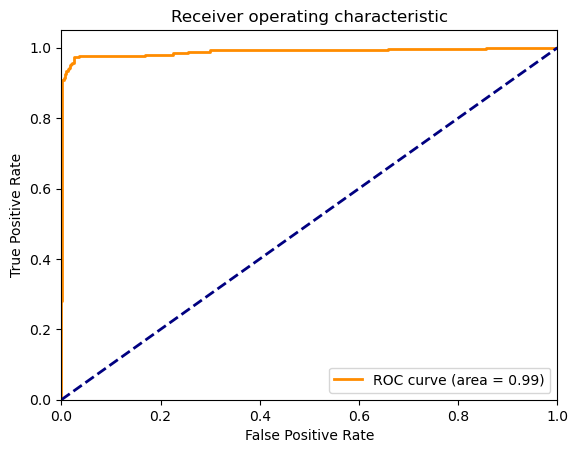

In [167]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = xgb.predict_proba(X_test)[:,1]
    
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [151]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3542 entries, 0 to 3541
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   3542 non-null   int64         
 1   Card                       3542 non-null   int64         
 2   Start_Date                 3529 non-null   datetime64[ns]
 3   Customer_Service_Calls     3542 non-null   int64         
 4   Credit_Limit               3542 non-null   float64       
 5   Total_Revolving_Balance    3542 non-null   int64         
 6   Average_Open_To_Buy        3542 non-null   float64       
 7   Average_Utilisation_Ratio  3542 non-null   float64       
 8   Age                        3542 non-null   int64         
 9   Gender                     3542 non-null   int64         
 10  Education                  3542 non-null   int64         
 11  Marital_Status             3542 non-null   int64         
 12  Depend

In [152]:
model = xgb

In [153]:
final_prediction = df_predict.drop(['Start_Date','Start_Day'], axis=1)

### Predict test data on trained model

In [154]:
p = model.predict(final_prediction)

[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; recall: (test=0.301) total time=   0.3s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; recall: (test=0.464) total time=   0.3s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; recall: (test=0.416) total time=   0.5s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; recall: (test=0.470) total time=   0.5s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; recall: (test=0.536) total time=   0.9s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; recall: (test=0.554) total time=   0.9s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsampl

[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; recall: (test=0.331) total time=   0.3s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; recall: (test=0.488) total time=   0.3s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; recall: (test=0.422) total time=   0.5s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; recall: (test=0.512) total time=   0.5s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; recall: (test=0.560) total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; recall: (test=0.440) total time=   0.9s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsampl

[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; recall: (test=0.410) total time=   0.3s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; recall: (test=0.422) total time=   0.3s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; recall: (test=0.428) total time=   0.5s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; recall: (test=0.434) total time=   0.5s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; recall: (test=0.434) total time=   0.9s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; recall: (test=0.548) total time=   0.9s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsampl

[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; recall: (test=0.458) total time=   0.3s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; recall: (test=0.313) total time=   0.3s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; recall: (test=0.506) total time=   0.5s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; recall: (test=0.380) total time=   0.5s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; recall: (test=0.542) total time=   1.0s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; recall: (test=0.494) total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=50, subsampl

In [155]:
submit_df = pd.read_csv('orig/customers_test.csv', index_col=0)
submit_df['Churn'] = p
submit_df.head()

,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Churn
Customer,,,,,,,,,,,,,,
774663629,Gold,2020-01-01,2,29663.0,1743,27920.0,0.059,51,M,Graduate,Single,3,€50K - €80K,0
720420396,Silver,2020-11-01,2,2032.0,1195,837.0,0.588,45,F,Unknown,Divorced,3,€30K - €50K,0
815283379,Silver,2020-01-01,1,17268.0,1197,16071.0,0.069,57,M,Graduate,Single,3,€100K +,0
764861610,Silver,2020-05-01,3,2264.0,0,2264.0,0.000,38,F,Primary level,Single,2,Less than €30K,0
742798818,Silver,2020-01-01,1,2192.0,1464,728.0,0.668,45,F,MSc,Unknown,4,Less than €30K,0


In [157]:
result_df = submit_df.drop(['Card','Start_Date','Customer_Service_Calls','Credit_Limit','Total_Revolving_Balance','Average_Open_To_Buy','Average_Utilisation_Ratio','Age','Gender',
                         'Education','Marital_Status','Dependents','Income'], axis=1)

In [158]:
result_df.head()

,Churn
Customer,
774663629,0
720420396,0
815283379,0
764861610,0
742798818,0


In [159]:
# result_df['Churn'] = result_df['Churn'].map({0:'No',1:'Yes'})
result_df['Churn'] = ['Yes' if p >= 0.5 else 'No' for p in result_df['Churn']]

In [160]:
result_df.head()

,Churn
Customer,
774663629,No
720420396,No
815283379,No
764861610,No
742798818,No


### Saving the submission file to output folder

In [161]:
result_df.to_csv('output/submission.csv')

In [162]:
result_df.shape

(3542, 1)

In [163]:
result_df.tail()

,Churn
Customer,
784491579,No
750122800,Yes
777178751,No
711974616,No
763698753,No


In [164]:
result_df.Churn.value_counts()

No     3079
Yes     463
Name: Churn, dtype: int64